In [1]:
%matplotlib inline
import time
import itertools
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R
from coppeliasim_zmqremoteapi_client import *

np.set_printoptions(precision=3, suppress=True)

SCENE_PATH = '/Users/kuang-yujeng/UR_2Cams.ttt'
WAIT_INTERVAL = 0.1 # 0.1s
TIMEOUT = 3 # 3s
ACCEPT_RERR = 0.2
ACCEPT_TERR = 0.0005
ACCEPT_STOP_VEL = 1e-3

In [2]:
# Step 1: Connect to CoppeliaSim using ZeroMQ Remote API
def connect_to_coppeliasim():
    client = RemoteAPIClient()
    sim = client.require('sim')
    sim.stopSimulation(True)
    sim.loadScene(SCENE_PATH)
    sim.startSimulation()
    return client, sim

# Step 2: Get object handles
def get_handles(sim):
    ur_base = sim.getObject('/UR10')
    ur_ee = sim.getObject('/UR10/connection')
    cam1 = sim.getObject('/UR10/kinect[0]/rgb')
    cam2 = sim.getObject('/UR10/kinect[1]/rgb')
    ur_ee_target = sim.getObject('/UR10/connection_manipSphere')
    return ur_base, ur_ee, cam1, cam2, ur_ee_target

def get_cv2_bgr(camera_bgr):
    img, [resX, resY] = sim.getVisionSensorImg(camera_bgr)
    img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)
    return cv2.flip(img, 0)

def set_frame_pose(sim, from_frame, to_frame, T):
    sim.setObjectMatrix(to_frame, from_frame, T[:3].ravel())

def get_frame_pose(sim, from_frame, to_frame):
    T = np.eye(4, dtype=np.float32)
    T[:3,:4] = np.array(sim.getObjectMatrix(to_frame, from_frame)).reshape(3,4)
    return T

def pose_error(T, T_target):
    t_err = np.linalg.norm(T[:3,-1]-T_target[:3,-1])
    r_err = T[:3,:3]@T_target[:3,:3].T
    r_err = np.degrees(np.arccos(np.clip((np.trace(r_err)-1)/2, -1, 1)))
    return r_err, t_err

def wait_robot_move(T_target, get_pose_fn, get_vel_fn):
    t_start = time.time()
    r_err, t_err = np.inf, np.inf
    while True:
        t_elapsed = time.time() - t_start
        if t_elapsed > TIMEOUT:
            return False, r_err, t_err
        time.sleep(WAIT_INTERVAL)
        T = get_pose_fn()
        v_linear, v_angular = get_vel_fn()
        v_linear = np.mean(v_linear)
        v_angular = np.mean(v_angular)
        r_err, t_err = pose_error(T, T_target)
        if r_err < ACCEPT_RERR and t_err < ACCEPT_TERR and v_linear < ACCEPT_STOP_VEL and v_angular < ACCEPT_STOP_VEL:
            return True, r_err, t_err

def set_frame_pose_and_wait(sim, from_frame, ik_frame, ee_frame, T):
    set_frame_pose(sim, from_frame, ik_frame, T)
    return wait_robot_move(T, lambda: get_frame_pose(sim, from_frame, ee_frame), lambda: sim.getObjectVelocity(ee_frame))

In [3]:
client, sim = connect_to_coppeliasim()
ur_base, ur_ee, cam1, cam2, ur_ee_target = get_handles(sim)

In [4]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 1e-5)
flags = cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_FIX_PRINCIPAL_POINT + cv2.CALIB_ZERO_TANGENT_DIST + cv2.CALIB_FIX_FOCAL_LENGTH + cv2.CALIB_FIX_K1 + cv2.CALIB_FIX_K2 + cv2.CALIB_FIX_K3 + cv2.CALIB_FIX_K4 + cv2.CALIB_FIX_K5 + cv2.CALIB_FIX_K6
# Detect checkerboard corners in the images
checkerboard_size = (10, 7)  # Example size, adjust as needed
unit = 0.025 # in meters
objp = np.zeros((checkerboard_size[0]*checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2) * unit

In [5]:
img = get_cv2_bgr(cam1)
h, w = int(img.shape[0]), int(img.shape[1])

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

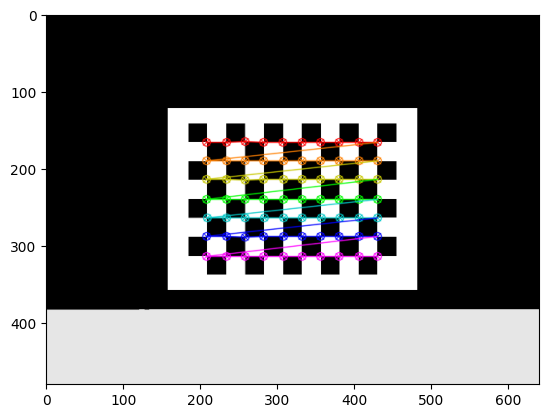

In [7]:
plt.imshow(cv2.drawChessboardCorners(img.copy(), checkerboard_size, corners, True)[...,::-1])
plt.show()

In [8]:
T_original = get_frame_pose(sim, ur_base, ur_ee)
T_original

array([[-0.   ,  0.   , -1.   , -0.35 ],
       [ 0.   ,  1.   ,  0.   ,  0.173],
       [ 1.   , -0.   , -0.   ,  0.754],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [9]:
tx, ty, tz = 0, 0, -0.1
rx, ry, rz = 15, 0, 0

T = np.array([[1, 0, 0, tx],
              [0, 1, 0, ty],
              [0, 0, 1, tz],
              [0, 0, 0, 1]], dtype=np.float32)
T_rot = np.eye(4, dtype=np.float32)
T_rot[:3,:3] = R.from_euler('zyx', [rz, ry, rx], degrees=True).as_matrix()
T = T@T_rot
T_target = T_original@T
set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_target)

(True, 0.0, 0.00010121838)

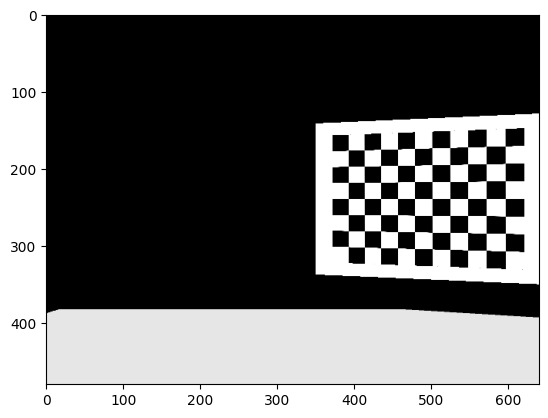

In [10]:
plt.imshow(get_cv2_bgr(cam1)[...,::-1])
plt.show()

In [11]:
set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_original)

(True, 0.0, 9.746222e-05)

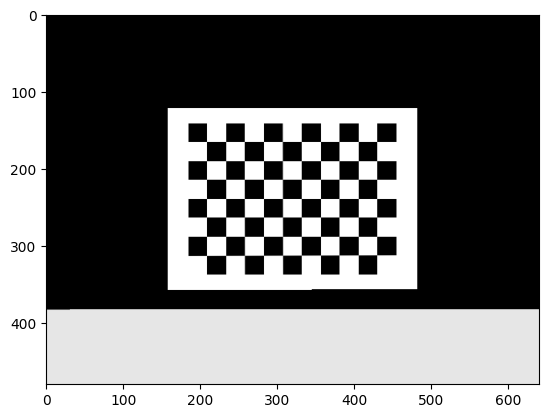

In [12]:
plt.imshow(get_cv2_bgr(cam1)[...,::-1])
plt.show()

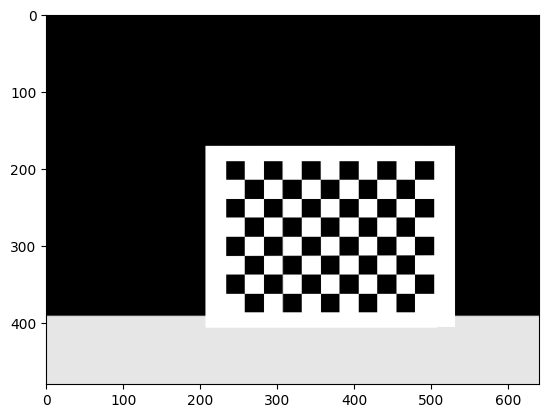

In [13]:
plt.imshow(get_cv2_bgr(cam2)[...,::-1])
plt.show()

In [14]:
x_range = [-0.05, -0.02, 0, 0.02, 0.05]
y_range = [-0.05, -0.02, 0, 0.02, 0.05]
z_range = [-0.1, 0, 0.05, 0.1]
alpha_range = [-10, 10]
beta_range = [-7, 7]
gamma_range = [0, 5]
Ts = []
for tz, tx, ty, rx, ry, rz in itertools.product(z_range, x_range, y_range, alpha_range, beta_range, gamma_range):
    T = np.array([[1, 0, 0, tx],
                  [0, 1, 0, ty],
                  [0, 0, 1, tz],
                  [0, 0, 0, 1]], dtype=np.float32)
    T_rot = np.eye(4, dtype=np.float32)
    T_rot[:3,:3] = R.from_euler('zyx', [rz, ry, rx], degrees=True).as_matrix()
    T = T@T_rot
    Ts.append(T)

In [15]:
len(Ts)

800

In [ ]:
image_points1 = []
image_points2 = []
obj_points = []
T_ee_poses = []

imgs1 = []
imgs2 = []

for T in Ts:
    T_target = T_original@T
    ret, r_err, t_err = set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_target)
    if not ret:
        continue

    T_ee_pose = get_frame_pose(sim, ur_base, ur_ee)
    
    img1 = get_cv2_bgr(cam1)
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
    if not ret:
        continue
    corners1 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    plt.imshow(cv2.drawChessboardCorners(img1.copy(), checkerboard_size, corners1, True)[...,::-1])
    plt.show()

    img2 = get_cv2_bgr(cam2)
    gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
    if not ret:
        continue
    corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    plt.imshow(cv2.drawChessboardCorners(img2.copy(), checkerboard_size, corners2, True)[...,::-1])
    plt.show()
    
    image_points1.append(corners1)
    image_points2.append(corners2)
    obj_points.append(objp)
    T_ee_poses.append(T_ee_pose)

    imgs1.append(img1)
    imgs2.append(img2)

In [17]:
len(image_points1)

485

In [18]:
_, mtx1, dist1, _, _ = cv2.calibrateCamera(obj_points, image_points1, (w, h), None, None, criteria=criteria, flags=flags)
_, mtx2, dist2, _, _ = cv2.calibrateCamera(obj_points, image_points2, (w, h), None, None, criteria=criteria, flags=flags)

In [19]:
mtx1

array([[590.04,   0.  , 319.5 ],
       [  0.  , 590.04, 239.5 ],
       [  0.  ,   0.  ,   1.  ]])

In [20]:
dist1

array([[0., 0., 0., 0., 0.]])

In [21]:
mtx2

array([[589.464,   0.   , 319.5  ],
       [  0.   , 589.464, 239.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [22]:
dist2

array([[0., 0., 0., 0., 0.]])

In [23]:
_, _, _, _, _, Rmtx, tmtx, _, _ = cv2.stereoCalibrate(obj_points, image_points1, image_points2, mtx1, dist1, mtx2, dist2, (w, h), flags=cv2.CALIB_FIX_INTRINSIC, criteria=criteria)
T_cam1to2 = np.eye(4, dtype=np.float32)
T_cam1to2[:3,:3] = Rmtx
T_cam1to2[:3,-1] = tmtx.ravel()
T_cam1to2

array([[ 1.   ,  0.   ,  0.   ,  0.05 ],
       [-0.   ,  1.   , -0.   ,  0.05 ],
       [-0.   ,  0.   ,  1.   , -0.001],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [24]:
get_frame_pose(sim, cam1, cam2)

array([[ 1.  ,  0.  , -0.  ,  0.05],
       [-0.  ,  1.  ,  0.  ,  0.05],
       [ 0.  , -0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ]], dtype=float32)

In [ ]:
hand_eye_R_gripper2base = []
hand_eye_R_target2cam = []
hand_eye_t_gripper2base = []
hand_eye_t_target2cam = []

for img_pt, obj_pt, ee_pose, img in zip(image_points1, obj_points, T_ee_poses, imgs1):
    ret, rvec, tvec = cv2.solvePnP(obj_pt, img_pt, mtx1, dist1, flags=cv2.SOLVEPNP_SQPNP)
    if ret:

        vis = cv2.drawFrameAxes(img.copy(), mtx1, dist1, rvec, tvec, 0.15, 2)
        plt.imshow(vis[...,::-1])
        plt.show()
        
        T_target2cam = np.eye(4, dtype=np.float32)
        T_target2cam[:3,:3] = cv2.Rodrigues(rvec)[0]
        T_target2cam[:3,-1] = tvec.ravel()
        T_target2cam = T_target2cam
        
        hand_eye_R_gripper2base.append(ee_pose[:3,:3])
        hand_eye_t_gripper2base.append(ee_pose[:3,-1])
        hand_eye_R_target2cam.append(T_target2cam[:3,:3])
        hand_eye_t_target2cam.append(T_target2cam[:3,-1])

In [26]:
R_tcp, t_tcp = cv2.calibrateHandEye(hand_eye_R_gripper2base, hand_eye_t_gripper2base, hand_eye_R_target2cam, hand_eye_t_target2cam)
T_tcp = np.eye(4, dtype=np.float32)
T_tcp[:3,:3] = R_tcp
T_tcp[:3,-1] = t_tcp.ravel()

In [27]:
T_tcp

array([[-0.002, -1.   , -0.   ,  0.075],
       [ 1.   , -0.002,  0.001, -0.014],
       [-0.001, -0.   ,  1.   ,  0.053],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [28]:
T_gl2cv = np.array([[-1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]], dtype=np.float32)

In [29]:
get_frame_pose(sim, ur_ee, cam1) @ T_gl2cv

array([[-0.   , -1.   ,  0.   ,  0.075],
       [ 1.   , -0.   , -0.   , -0.014],
       [ 0.   ,  0.   ,  1.   ,  0.056],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [30]:
T_tcp2 = T_tcp @ np.linalg.inv(T_cam1to2)
T_tcp2

array([[-0.002, -1.   , -0.001,  0.126],
       [ 1.   , -0.002,  0.   , -0.064],
       [-0.   , -0.001,  1.   ,  0.054],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [31]:
get_frame_pose(sim, ur_ee, cam2) @ T_gl2cv

array([[-0.   , -1.   ,  0.   ,  0.125],
       [ 1.   , -0.   , -0.   , -0.064],
       [ 0.   ,  0.   ,  1.   ,  0.056],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [32]:
x_range = [-0.05, 0.05]
y_range = [-0.05, 0.05]
z_range = [0]
alpha_range = [-10, 10]
beta_range = [-5, 5]
gamma_range = [-3, 3]
Ts = []
for tz, tx, ty, rx, ry, rz in itertools.product(z_range, x_range, y_range, alpha_range, beta_range, gamma_range):
    T = np.array([[1, 0, 0, tx],
                  [0, 1, 0, ty],
                  [0, 0, 1, tz],
                  [0, 0, 0, 1]], dtype=np.float32)
    T_rot = np.eye(4, dtype=np.float32)
    T_rot[:3,:3] = R.from_euler('zyx', [rz, ry, rx], degrees=True).as_matrix()
    T = T@T_rot
    Ts.append(T)

In [33]:
T_t2center = np.array([[1, 0, 0, unit*4.5],
                       [0, 1, 0, unit*2.5],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]], dtype=np.float32)
T_backward = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, -0.5],
                       [0, 0, 0, 1]], dtype=np.float32)

In [34]:
checkerboard_frame = sim.getObject('/checkerboard_base')

In [35]:
T_target_original = get_frame_pose(sim, ur_base, checkerboard_frame)
T_target_original

array([[-0.   , -0.   ,  1.   , -1.007],
       [-1.   ,  0.   , -0.   ,  0.158],
       [ 0.   , -1.   , -0.   ,  0.829],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [36]:
set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_original)
set_frame_pose_and_wait(sim, ur_base, checkerboard_frame, checkerboard_frame, T_target_original)

(True, 0.0, 0.0)

0.0 0.0


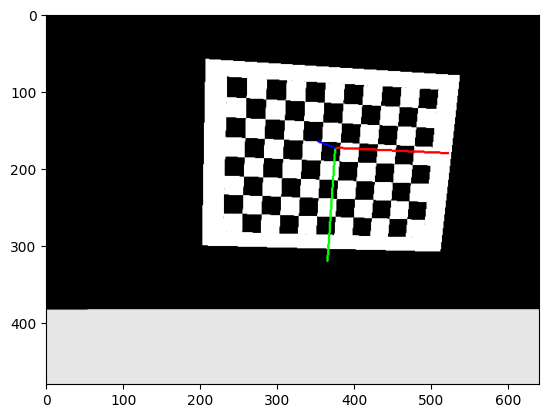

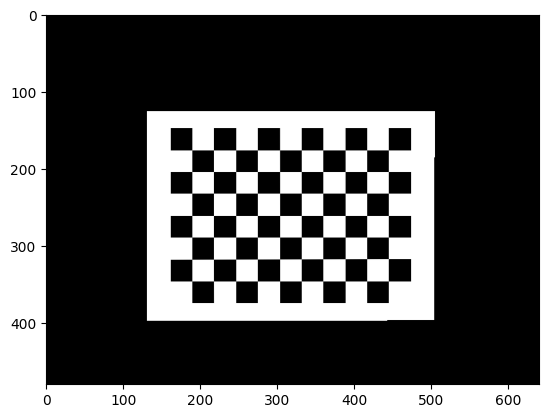

0.0 0.0


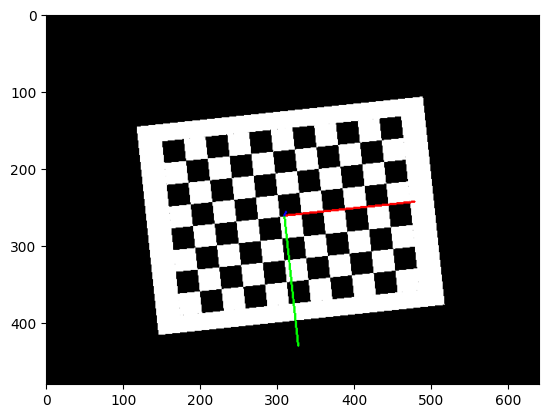

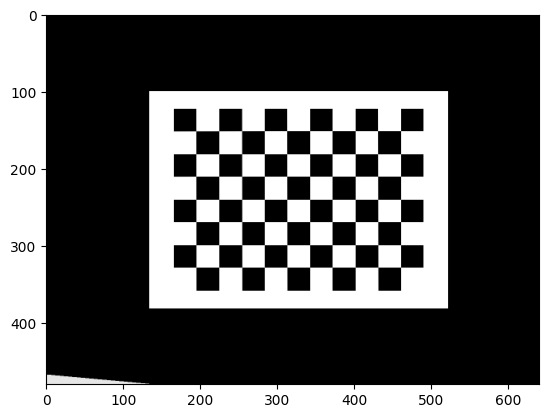

0.0 0.0


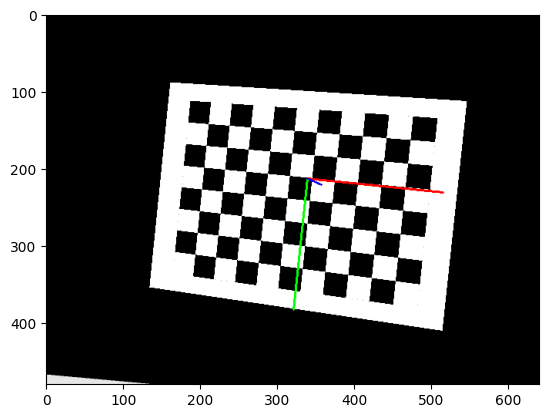

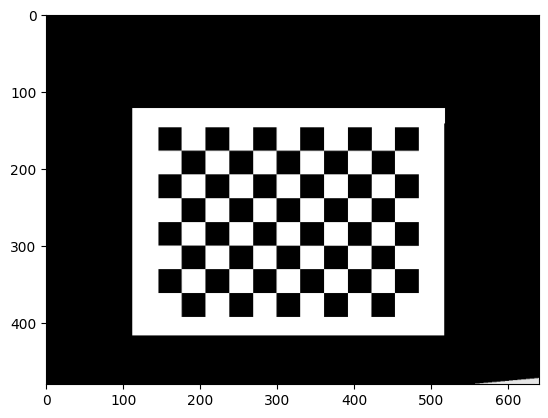

0.0 0.0


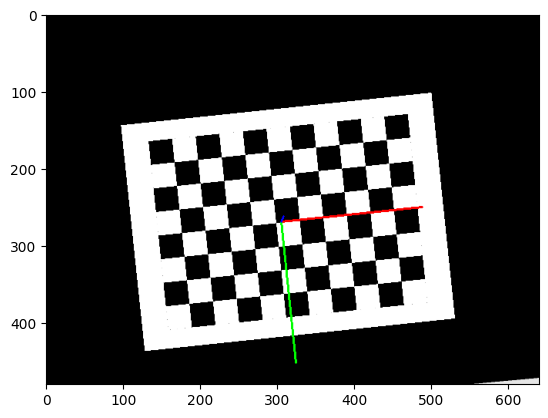

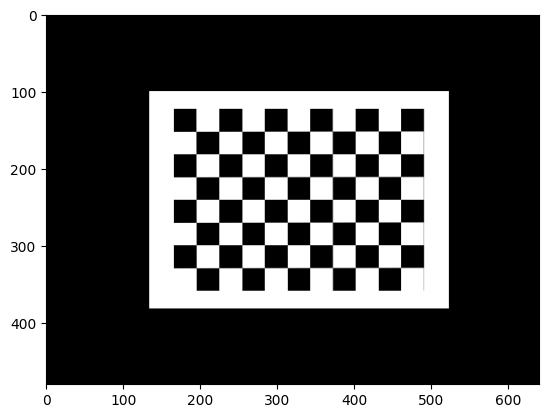

0.0 0.0


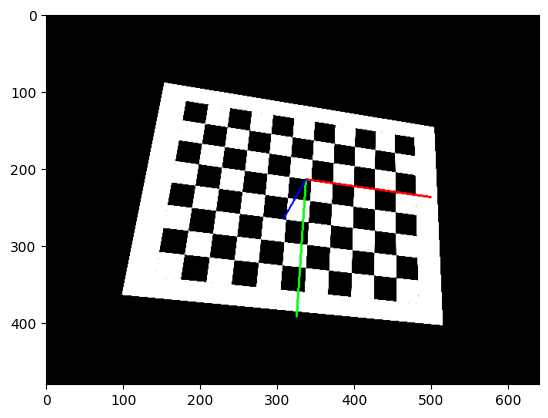

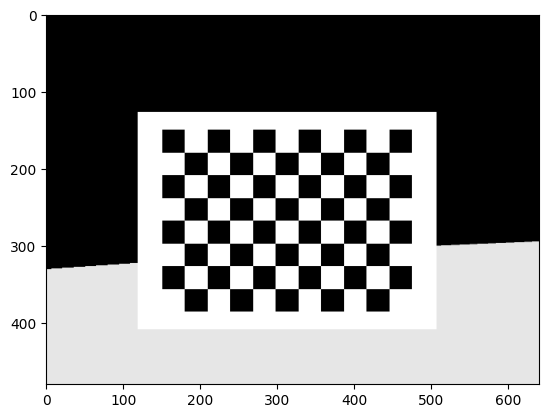

0.0 0.0


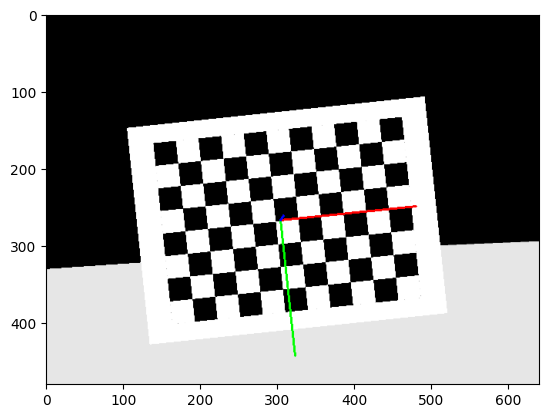

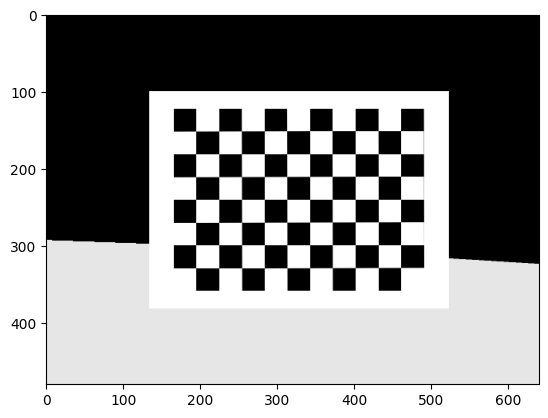

0.0 0.0


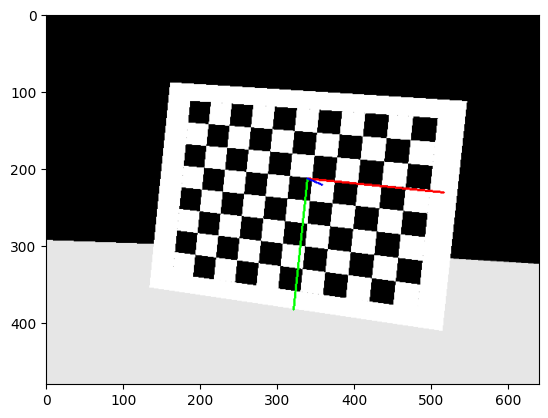

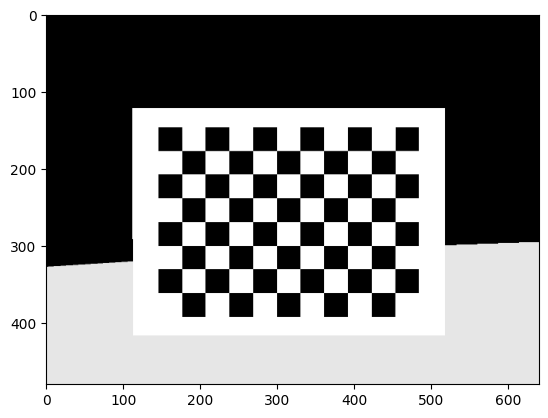

0.0 0.0


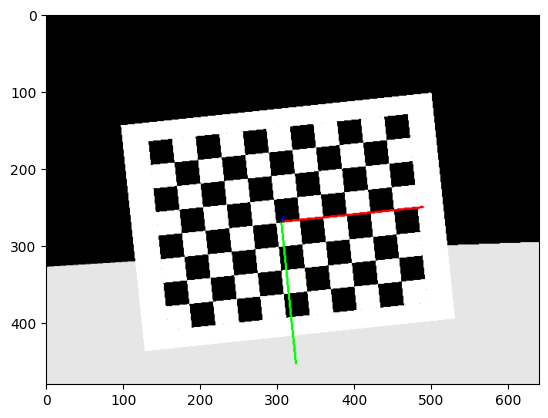

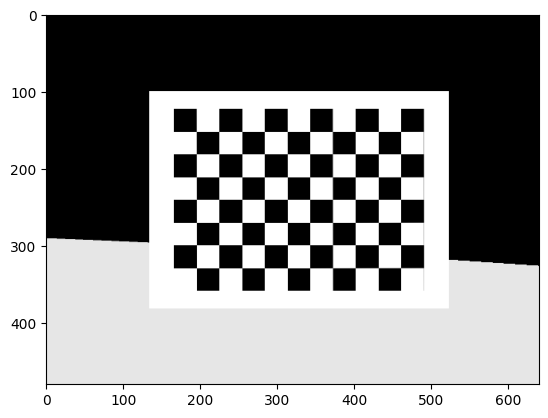

0.0 0.0


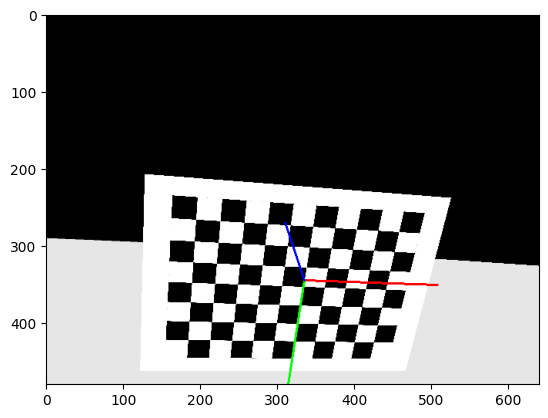

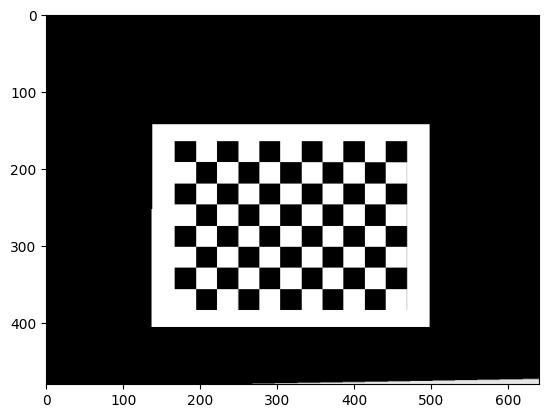

0.0 0.0


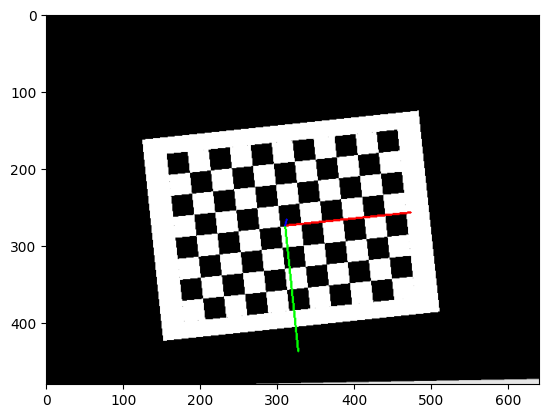

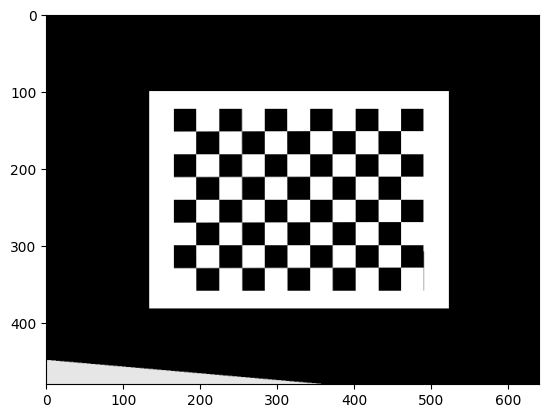

0.0 0.0


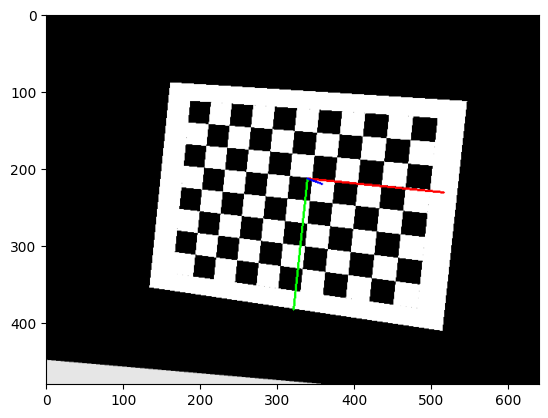

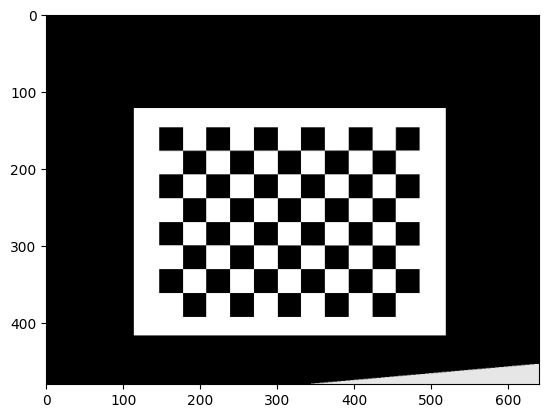

0.0 0.0


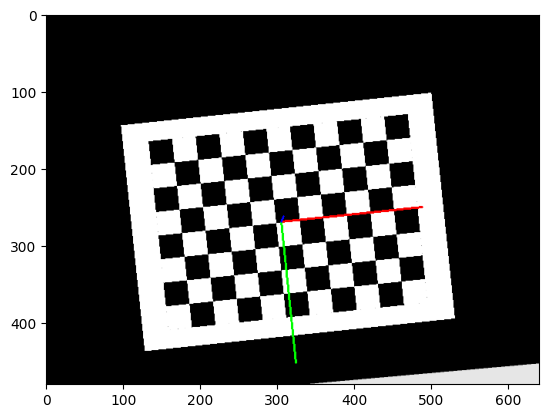

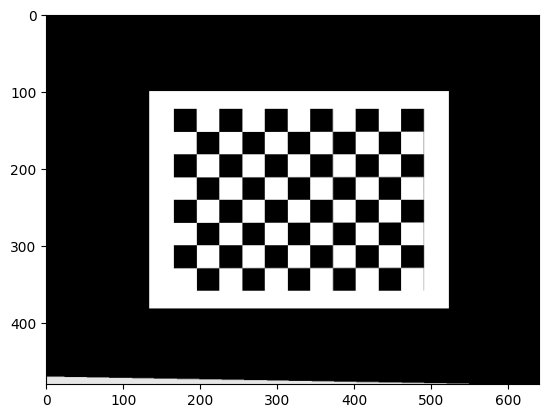

0.0 0.0


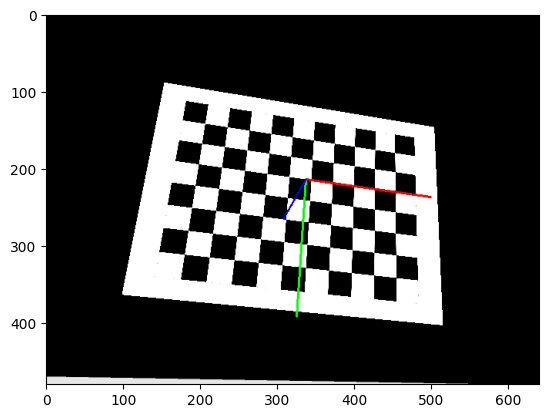

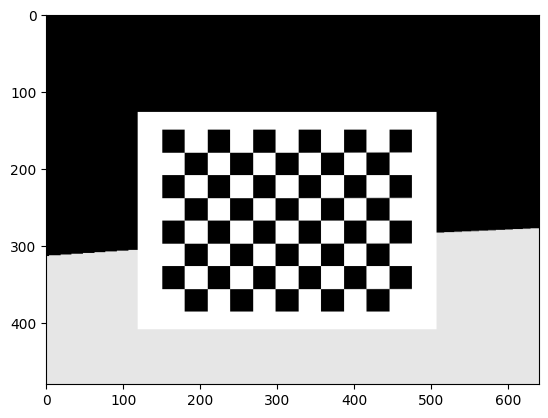

0.0 0.0


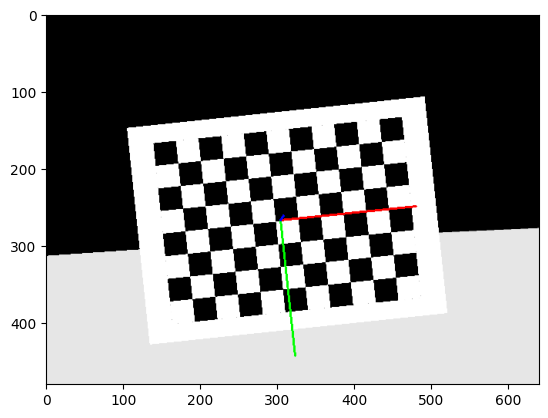

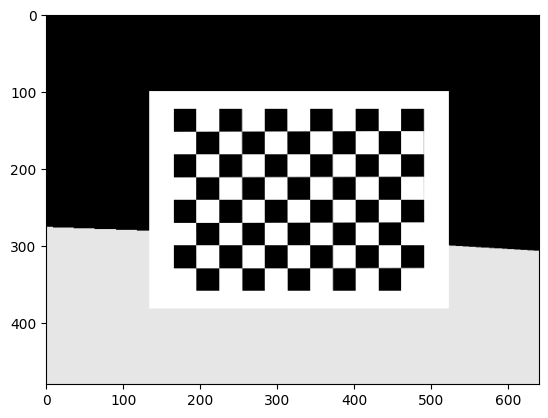

0.0 0.0


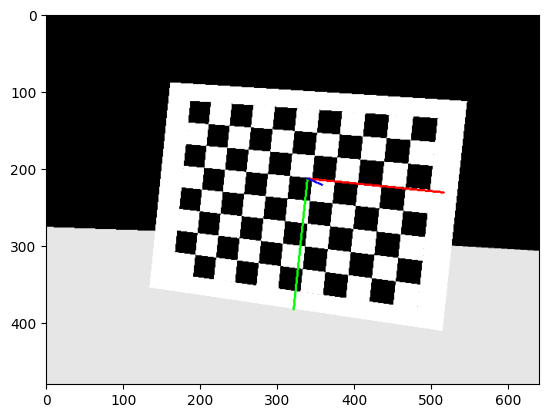

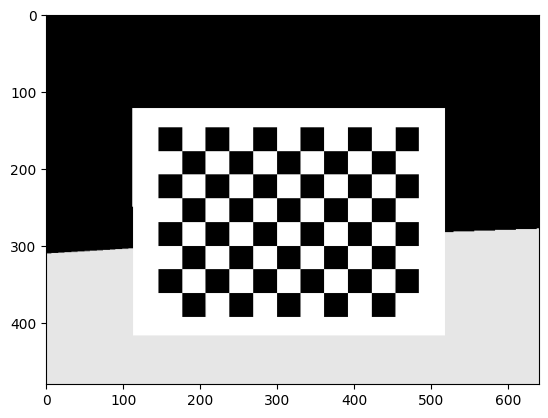

0.0 0.0


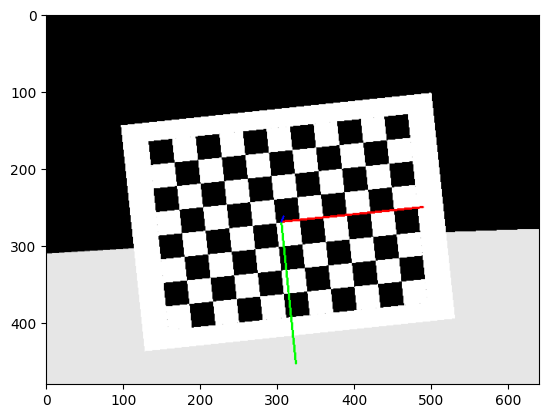

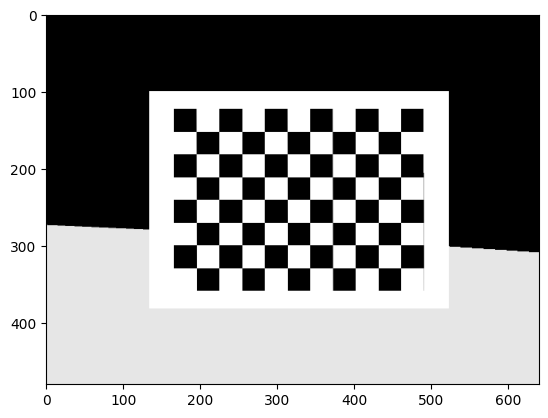

0.0 0.0


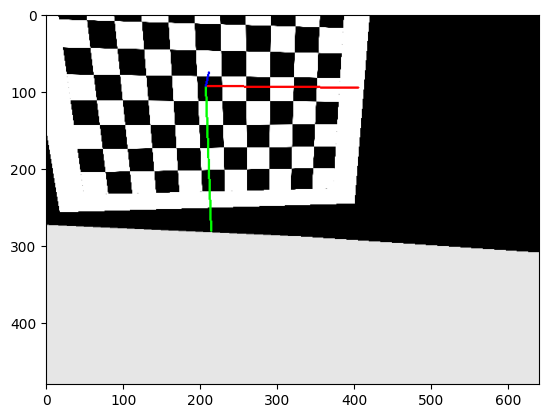

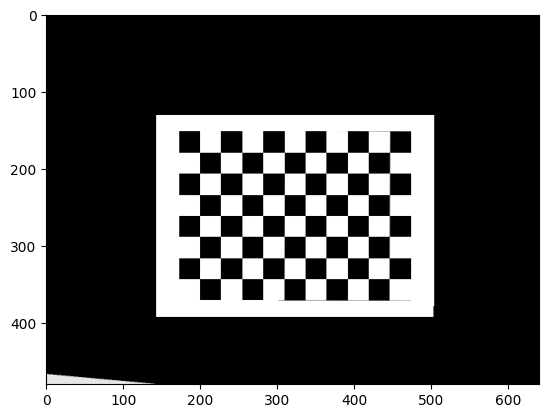

0.0 0.0


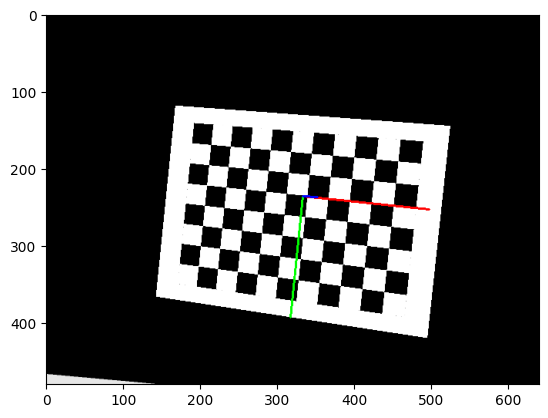

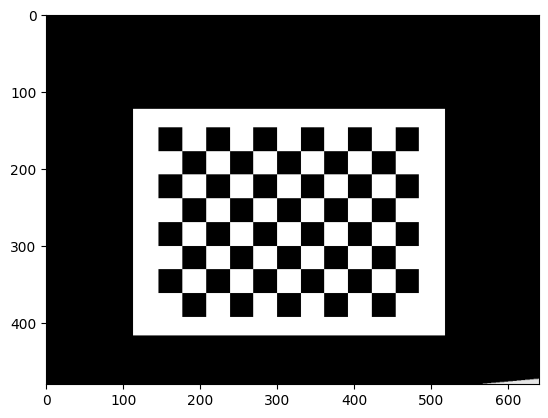

0.0 0.0


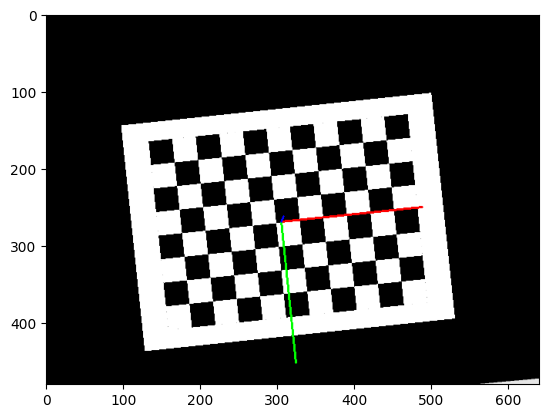

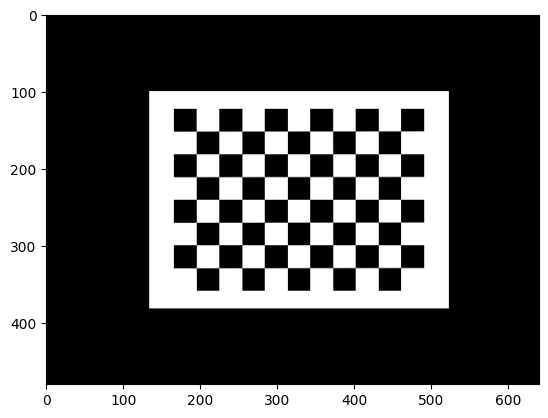

0.0 0.0


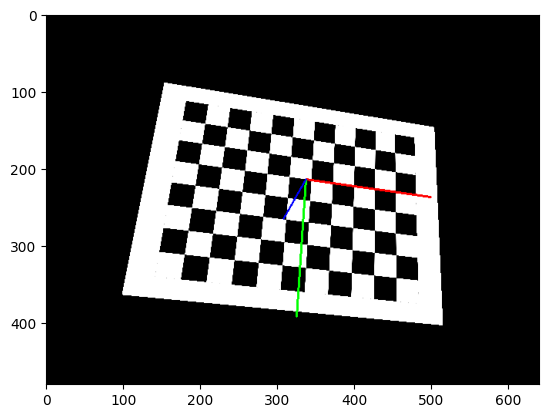

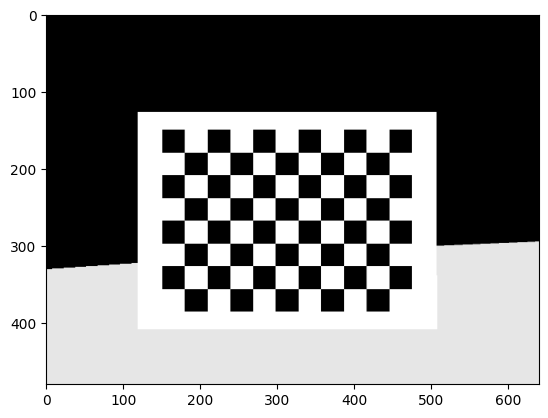

0.0 0.0


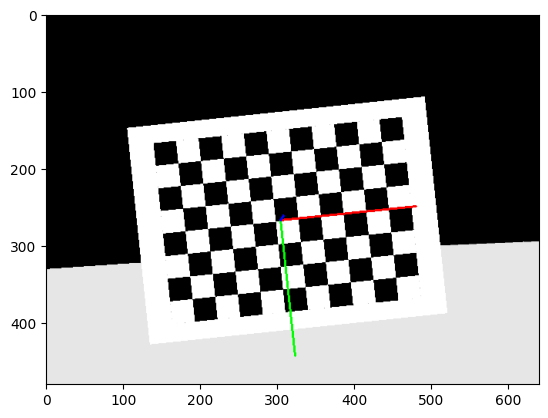

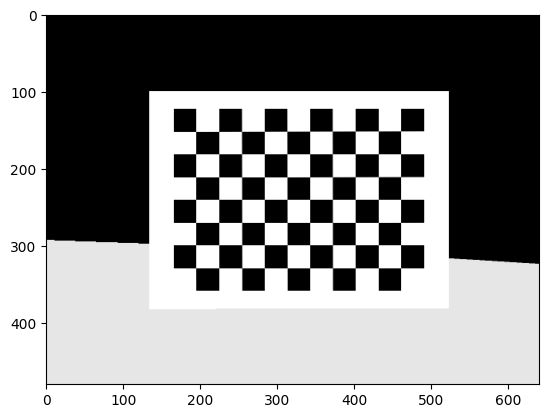

0.0 0.0


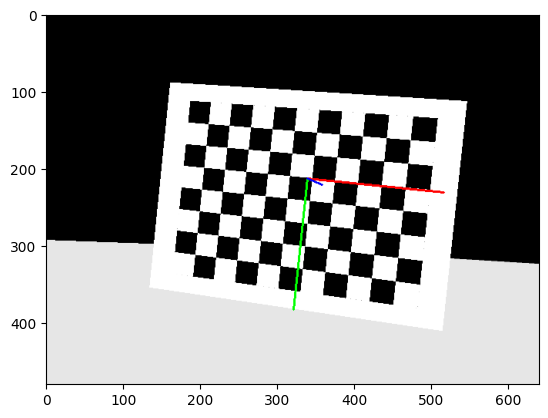

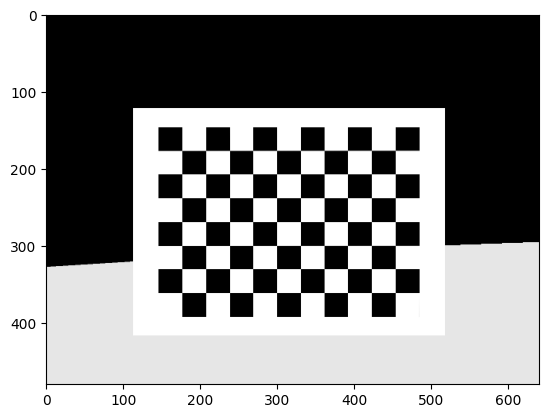

0.0 0.0


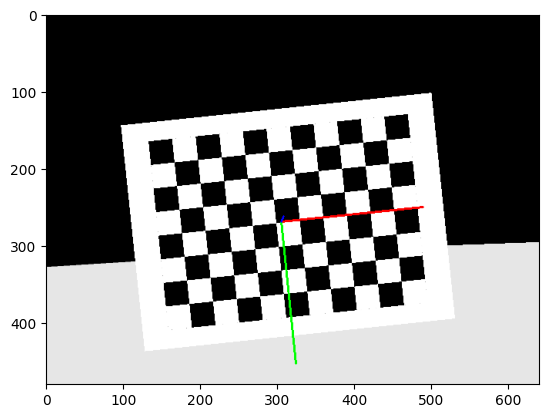

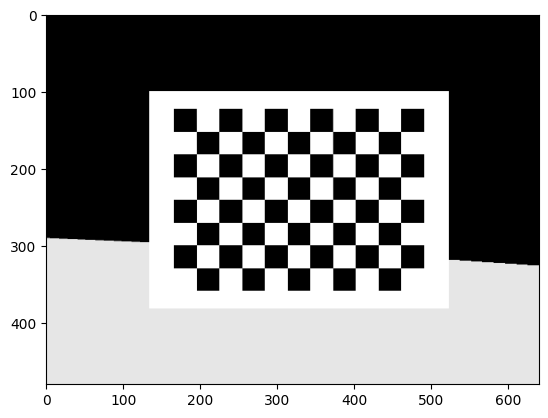

0.0 0.0


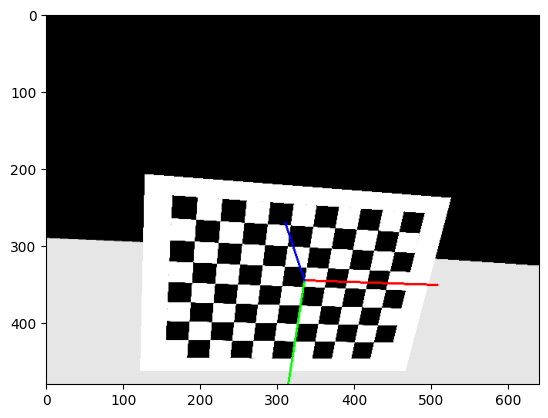

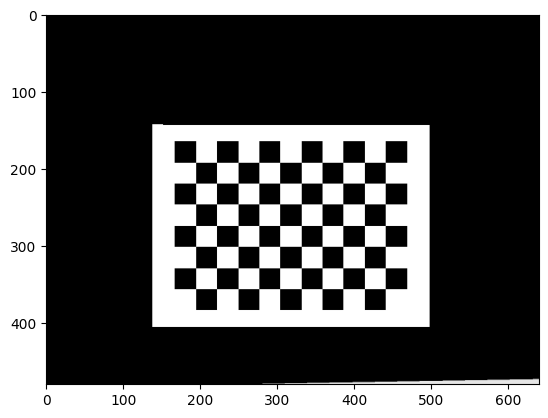

0.0 0.0


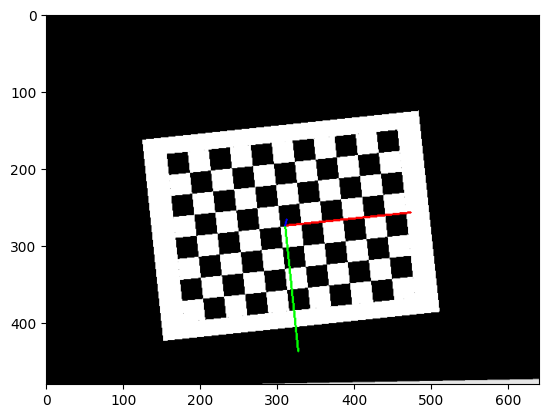

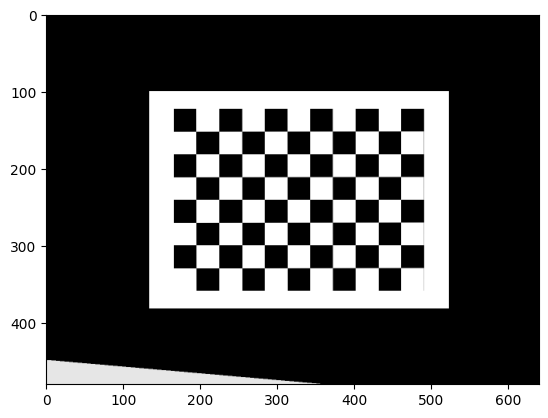

0.0 0.0


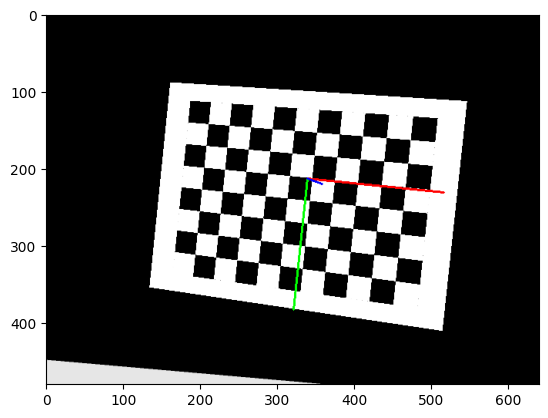

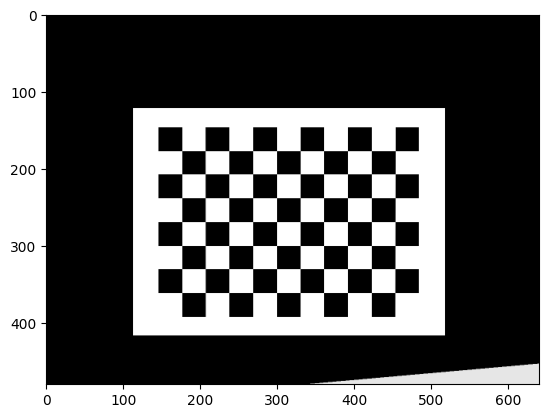

0.0 0.0


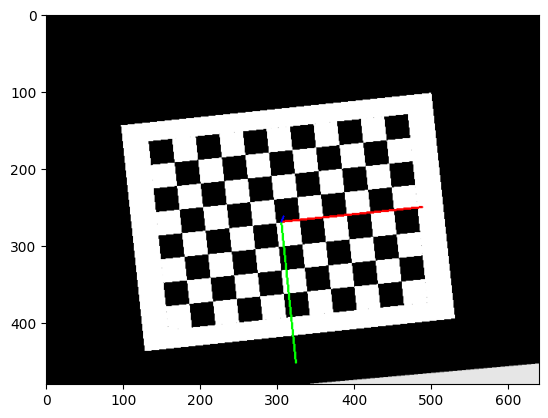

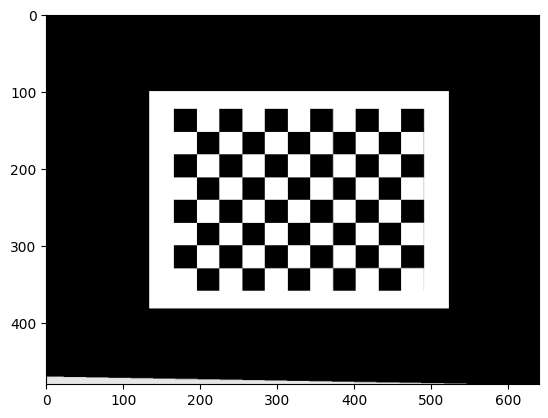

0.0 0.0


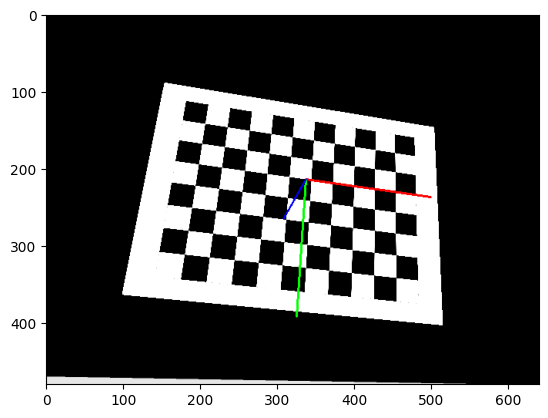

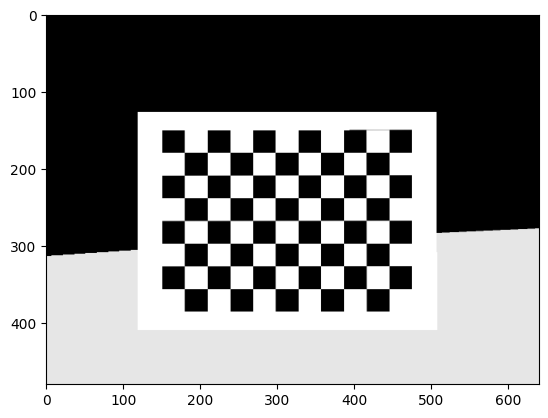

0.0 0.0


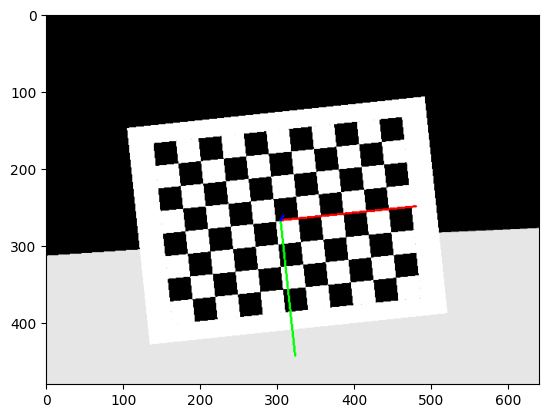

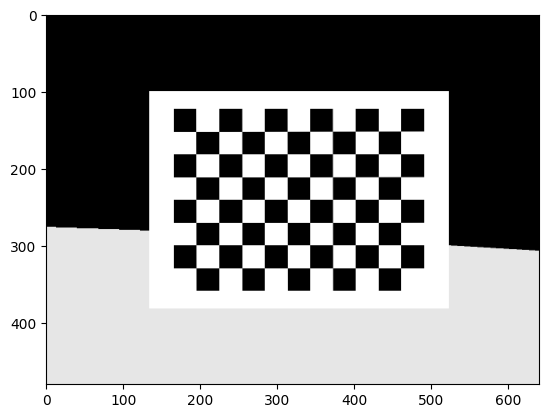

0.0 0.0


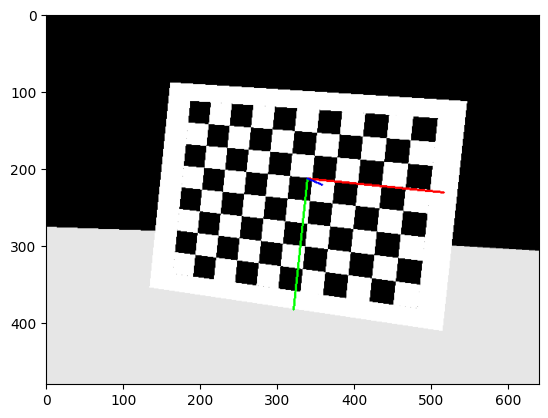

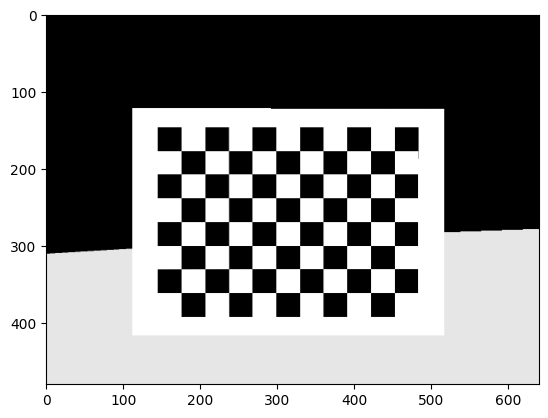

0.0 0.0


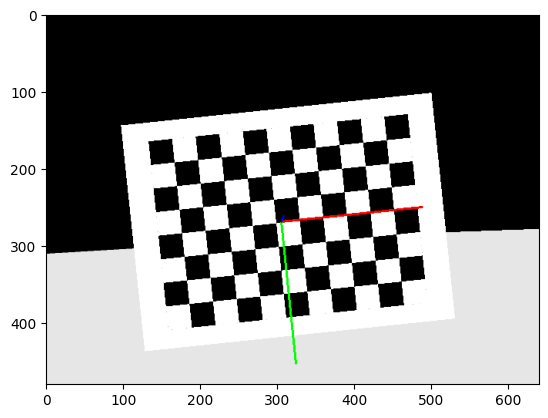

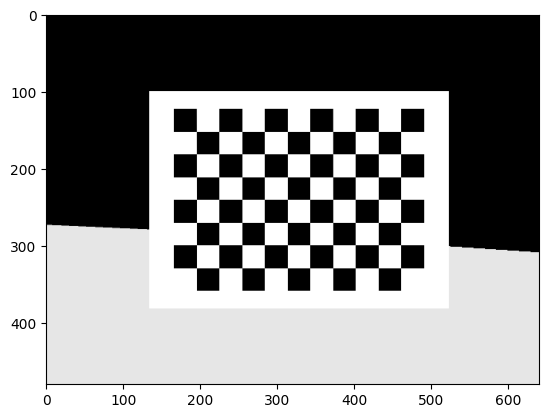

In [37]:
for T in Ts:
    T_target = T_target_original@T
    ret, r_err, t_err = set_frame_pose_and_wait(sim, ur_base, checkerboard_frame, checkerboard_frame, T_target)
    if not ret:
        continue
    img = get_cv2_bgr(cam1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
    if not ret:
        continue
    print(r_err, t_err)
    corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    ret, rvec, tvec = cv2.solvePnP(objp, corners, mtx1, dist1, flags=cv2.SOLVEPNP_SQPNP)
    if not ret:
        continue

    T_w2c = np.eye(4, dtype=np.float32)
    T_w2c[:3,:3] = cv2.Rodrigues(rvec)[0]
    T_w2c[:3,-1] = tvec.ravel()
    T_w2c = T_t2center @ T_w2c

    vis = cv2.drawFrameAxes(img.copy(), mtx1, dist1, cv2.Rodrigues(T_w2c[:3,:3])[0], T_w2c[:3,-1], 0.15, 2)
    plt.imshow(vis[...,::-1])
    plt.show()
    
    T_base2ee = get_frame_pose(sim, ur_base, ur_ee)
    T_new_ee = T_base2ee @ T_tcp @ T_w2c @ T_backward @ np.linalg.inv(T_tcp)
    
    set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_new_ee)

    img = get_cv2_bgr(cam1)
    plt.imshow(img[...,::-1])
    plt.show()

In [38]:
set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_original)
set_frame_pose_and_wait(sim, ur_base, checkerboard_frame, checkerboard_frame, T_target_original)

(True, 0.0, 0.0)

0.0 0.0


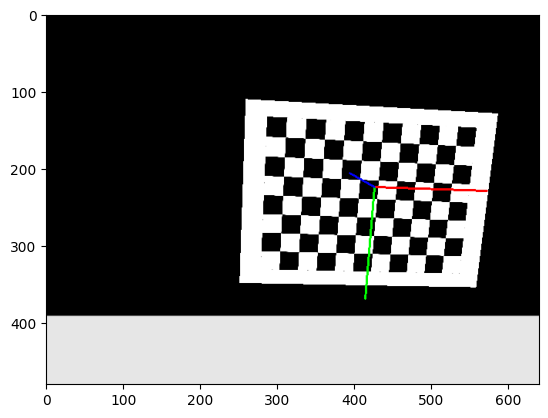

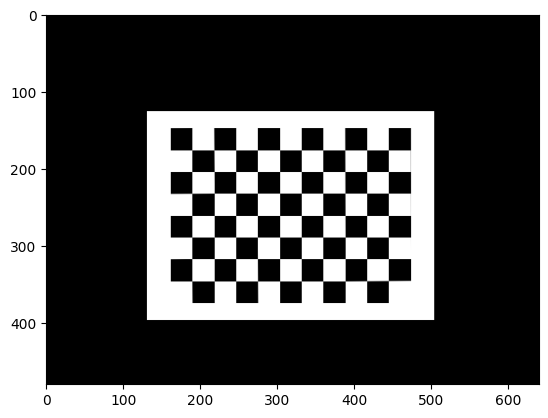

0.0 0.0


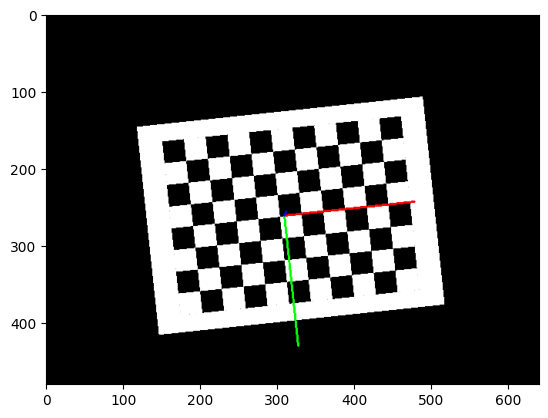

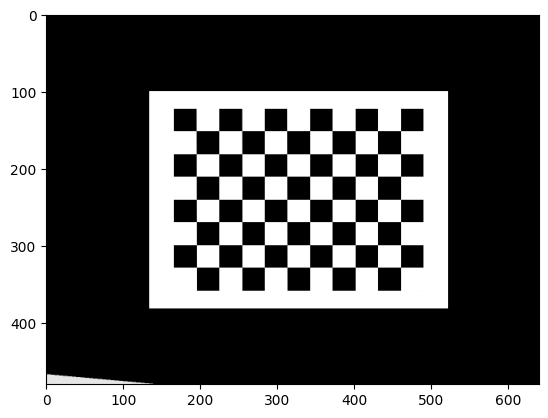

0.0 0.0


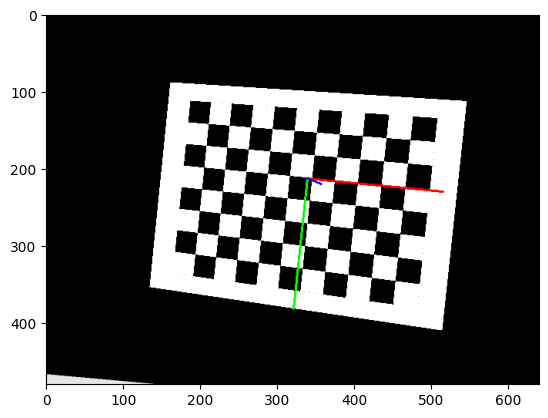

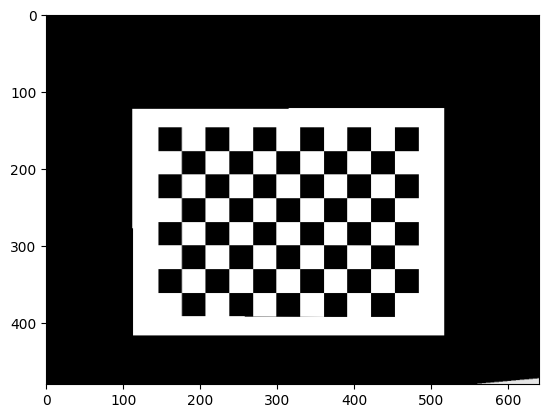

0.0 0.0


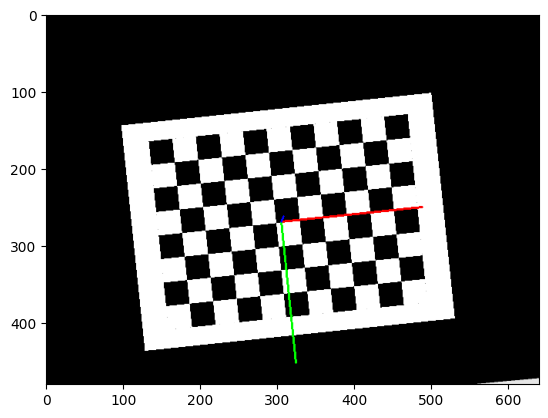

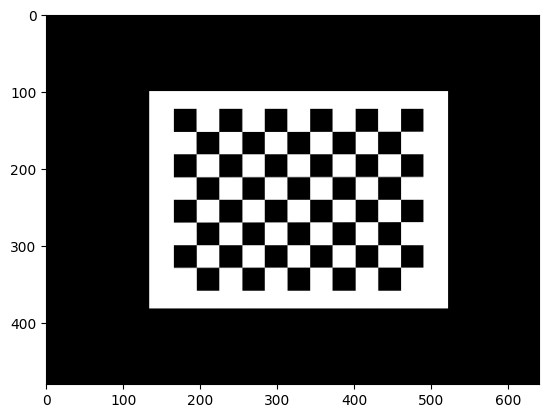

0.0 0.0


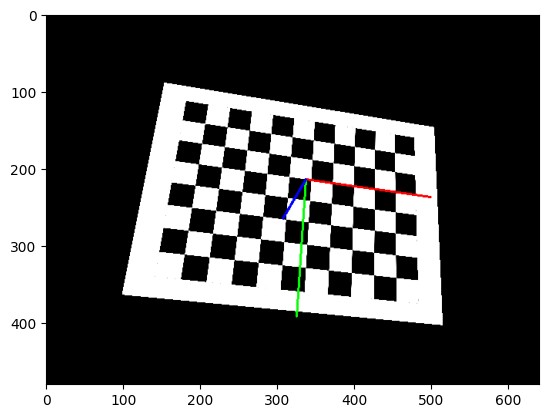

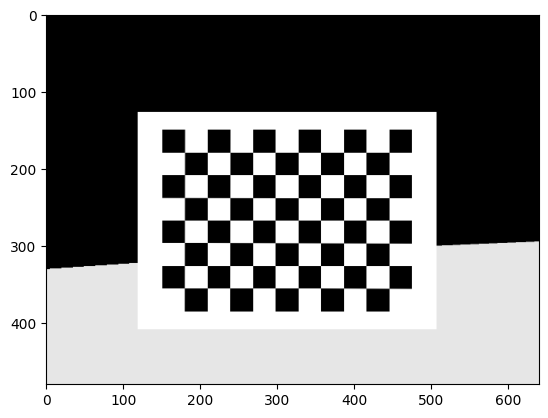

0.0 0.0


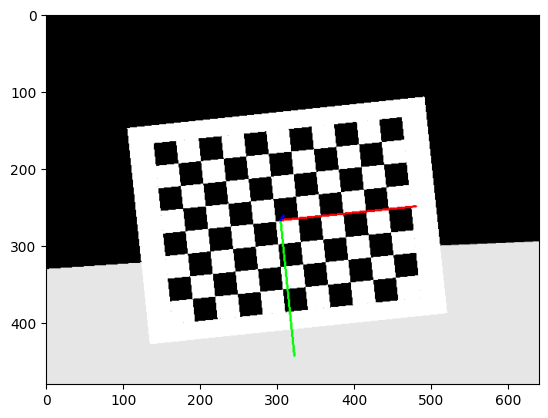

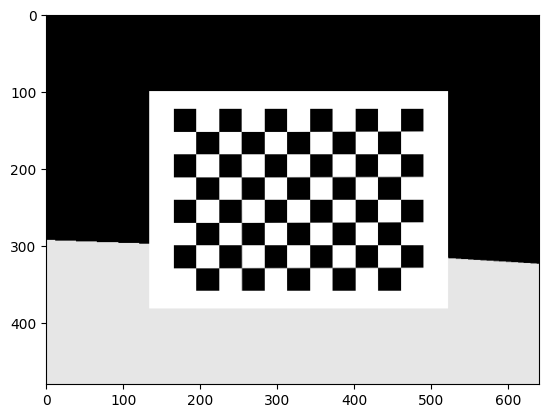

0.0 0.0


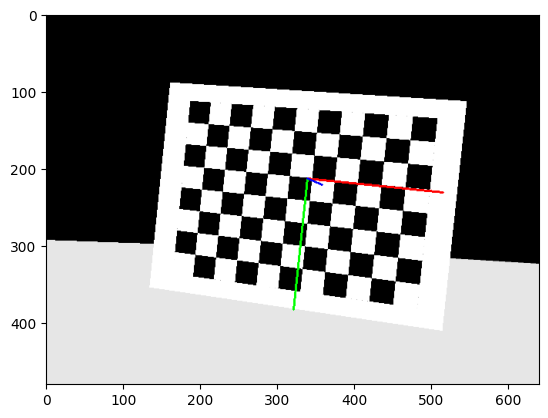

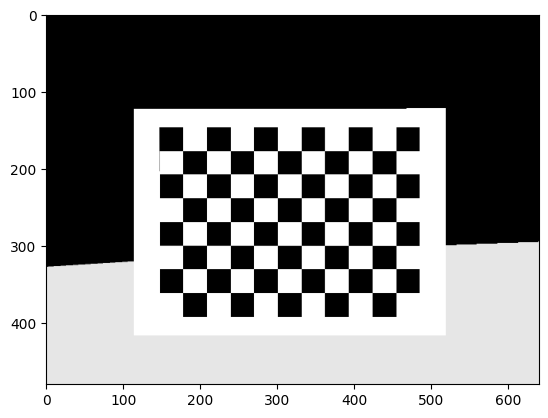

0.0 0.0


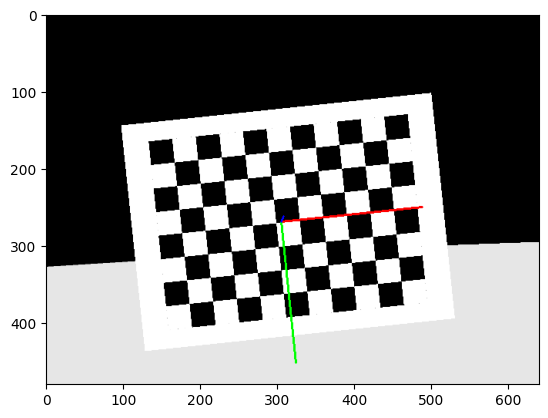

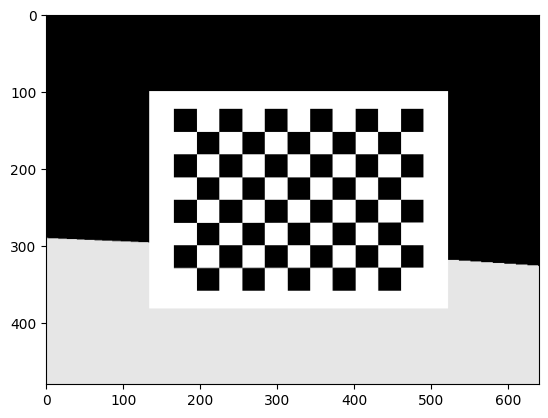

0.0 0.0


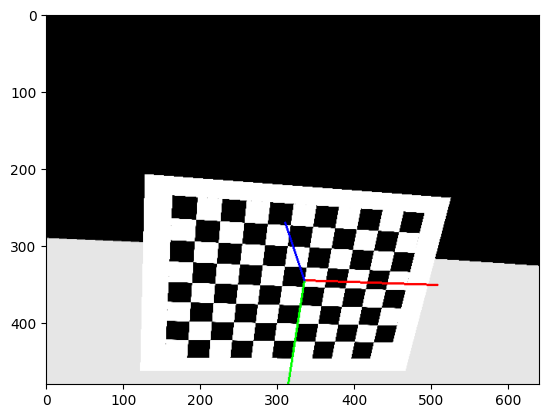

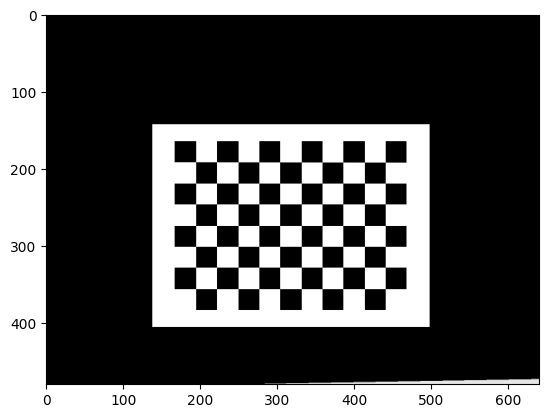

0.0 0.0


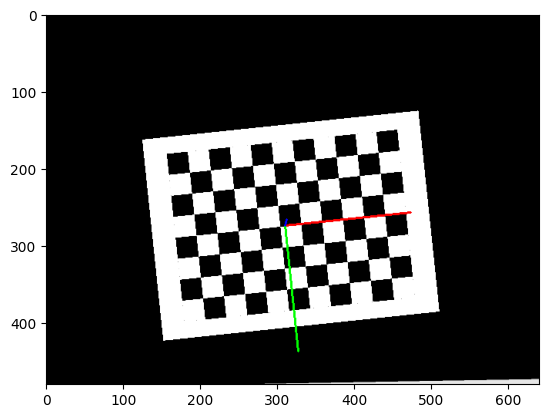

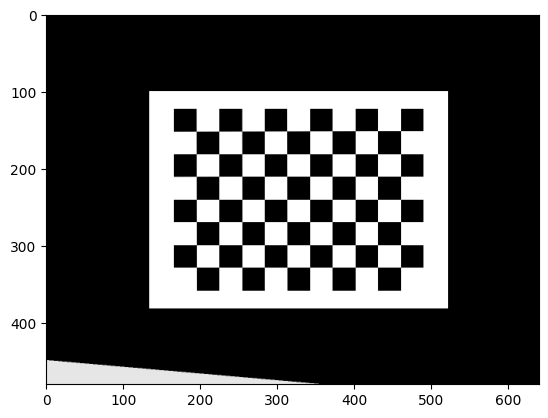

0.0 0.0


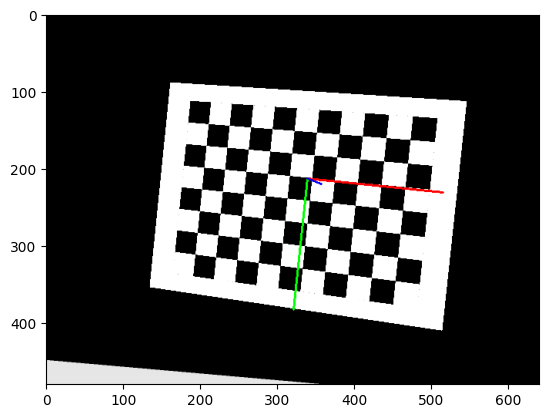

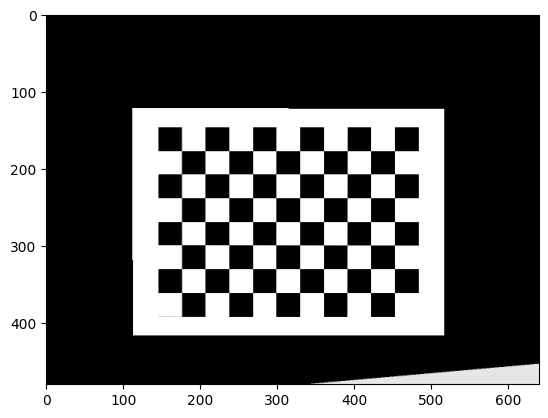

0.0 0.0


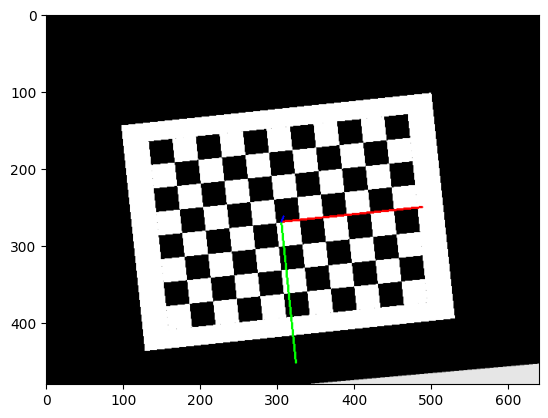

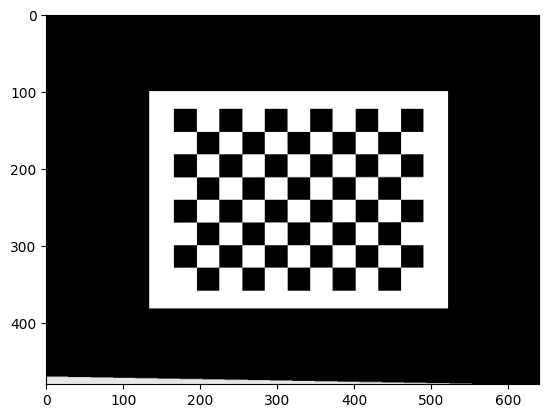

0.0 0.0


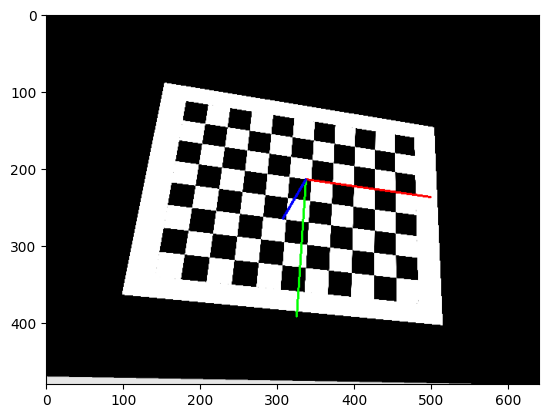

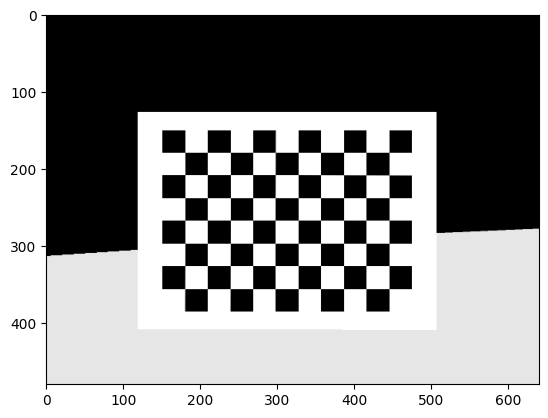

0.0 0.0


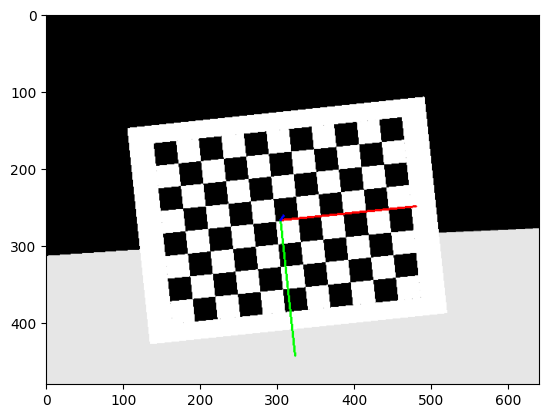

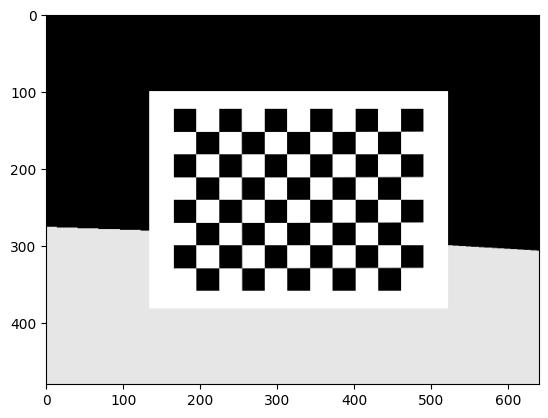

0.0 0.0


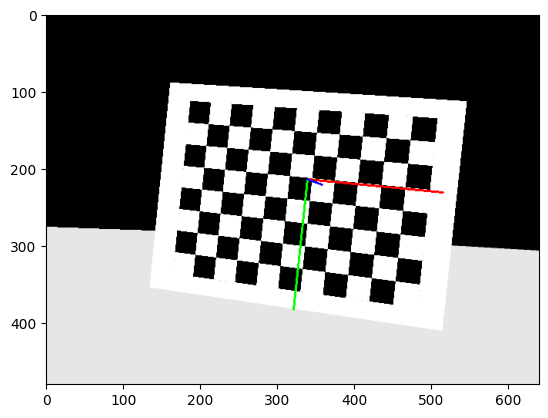

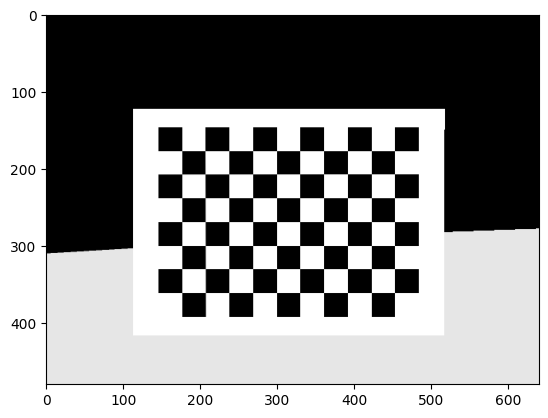

0.0 0.0


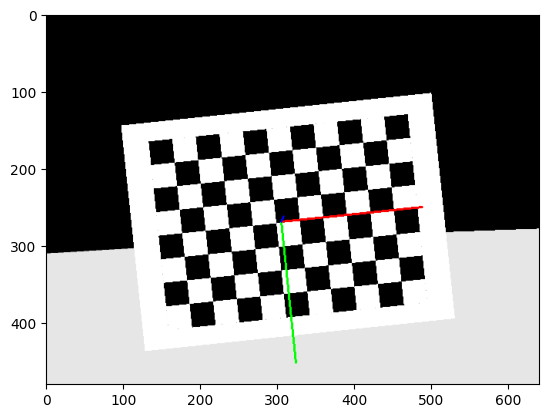

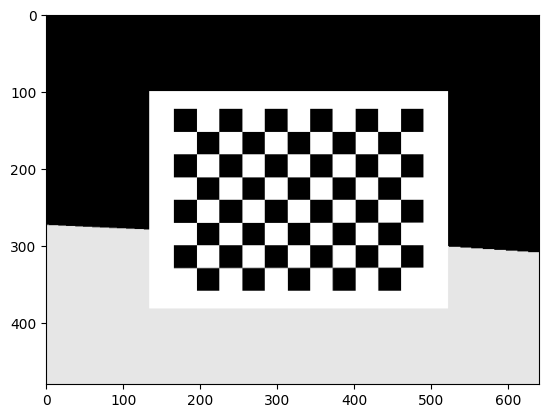

0.0 0.0


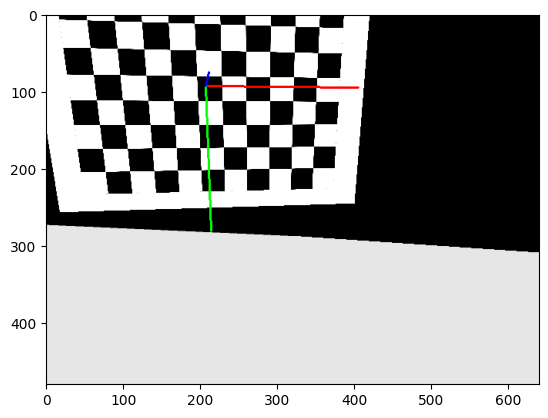

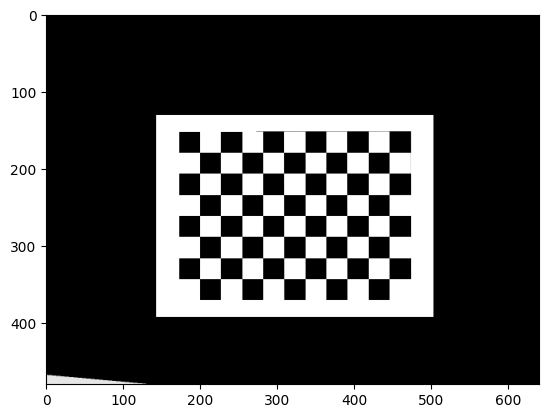

0.0 0.0


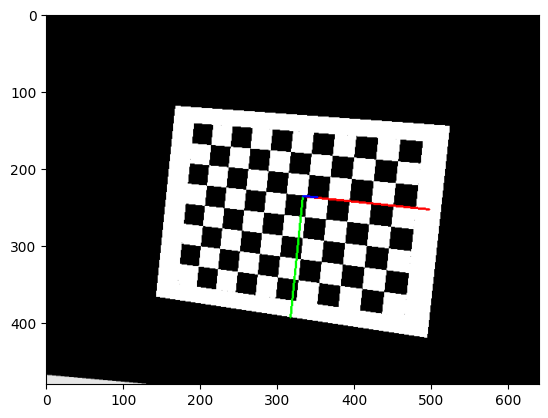

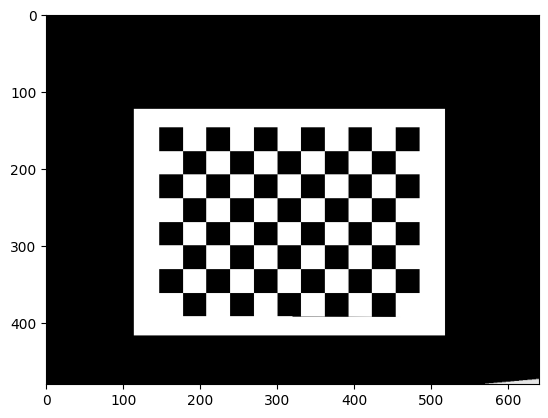

0.0 0.0


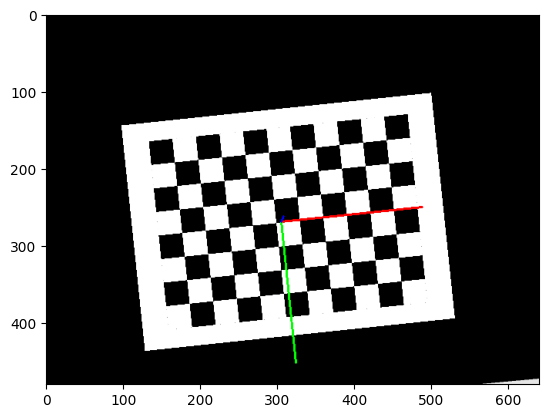

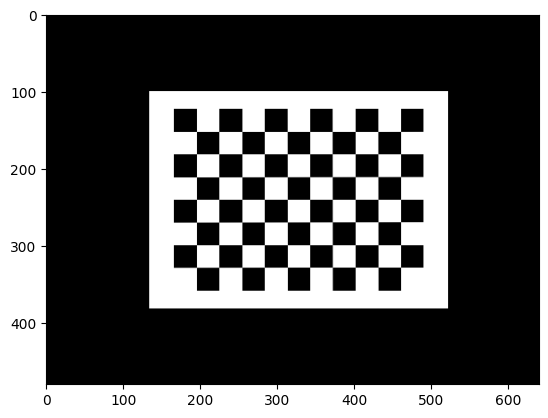

0.0 0.0


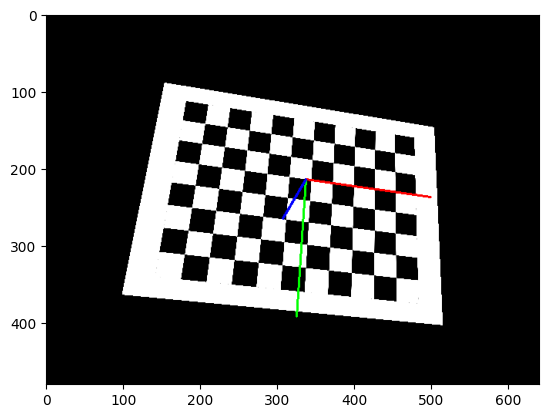

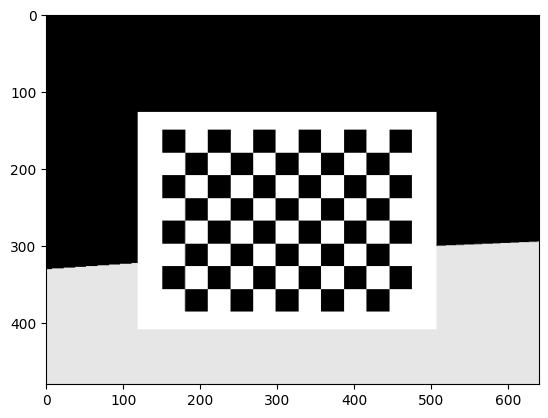

0.0 0.0


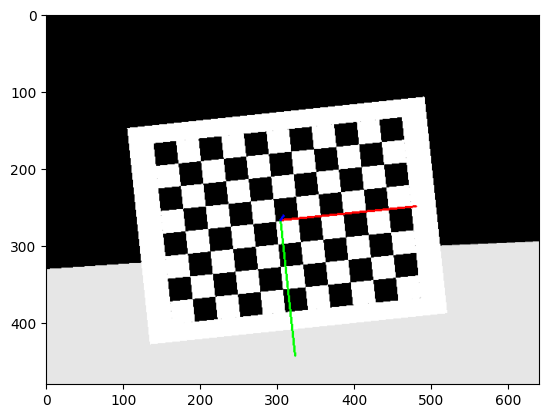

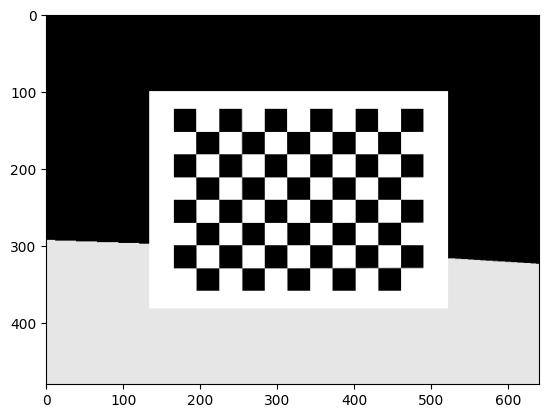

0.0 0.0


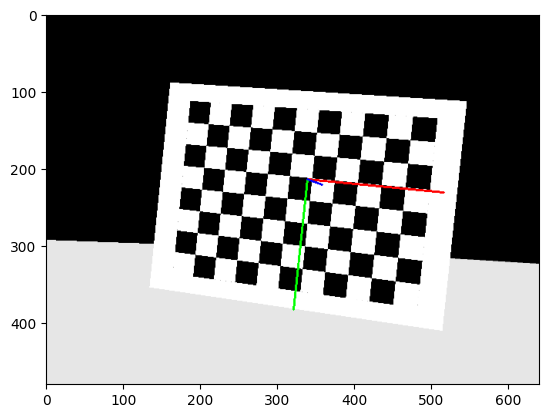

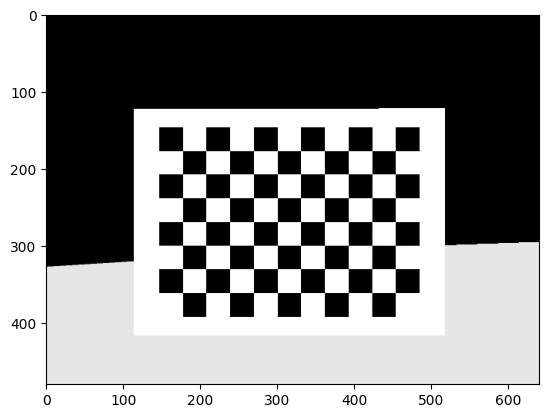

0.0 0.0


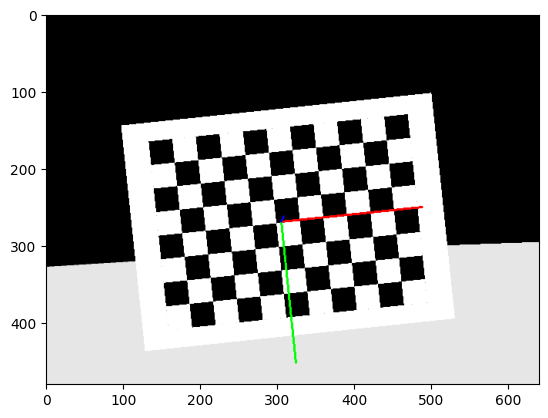

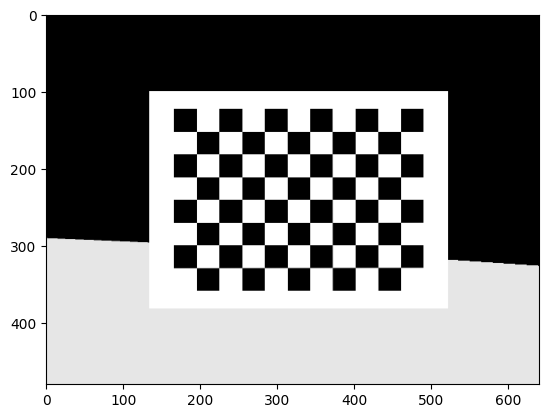

0.0 0.0


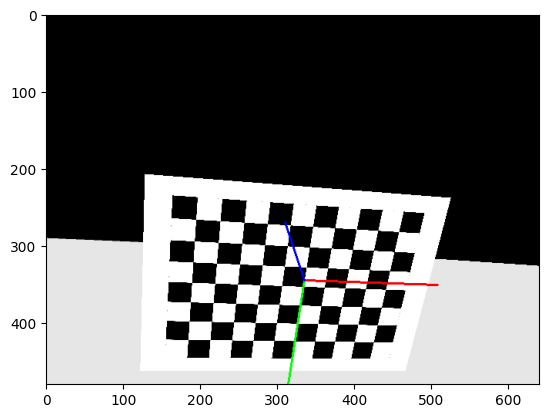

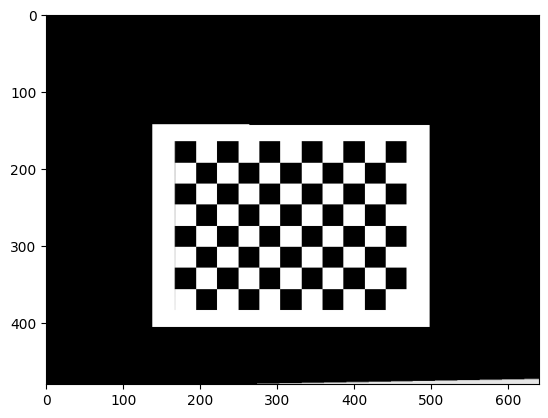

0.0 0.0


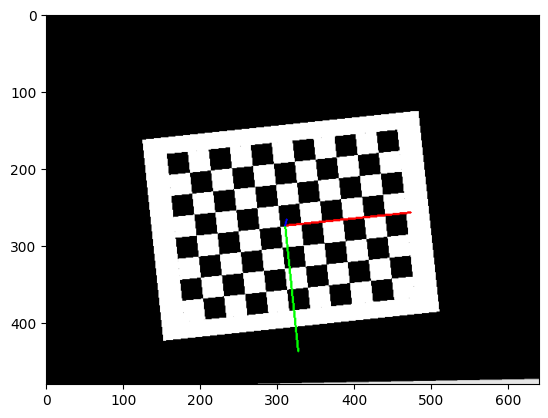

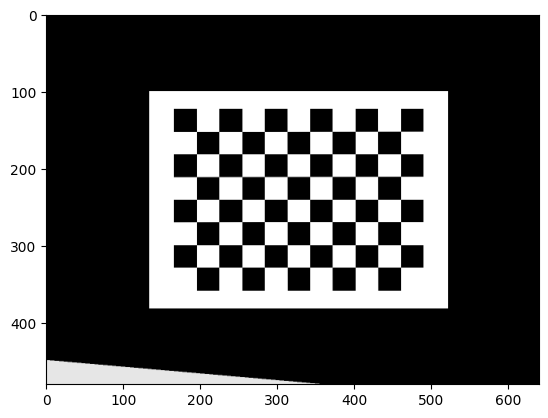

0.0 0.0


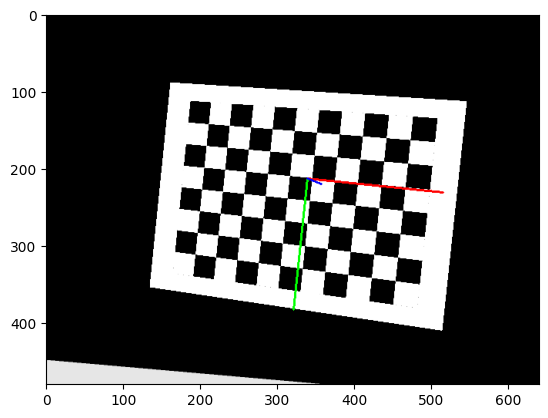

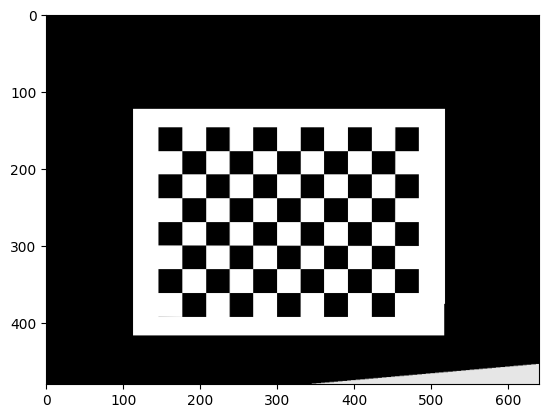

0.0 0.0


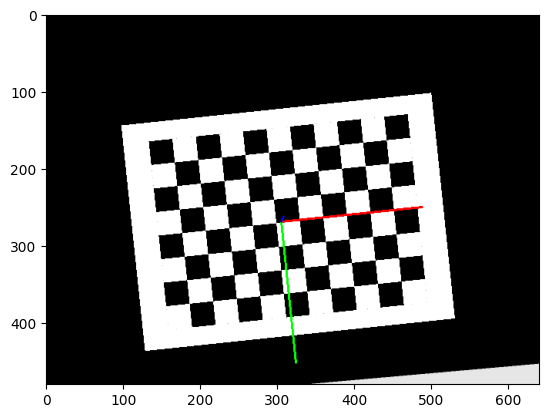

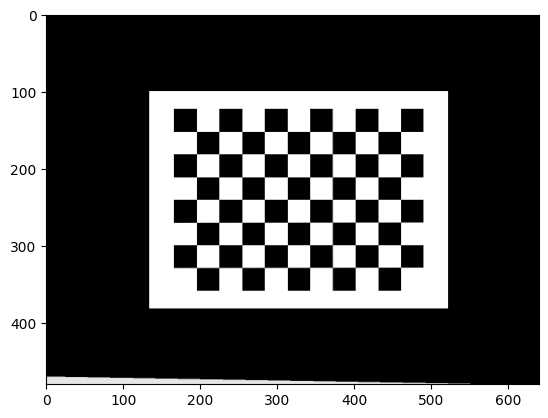

0.0 0.0


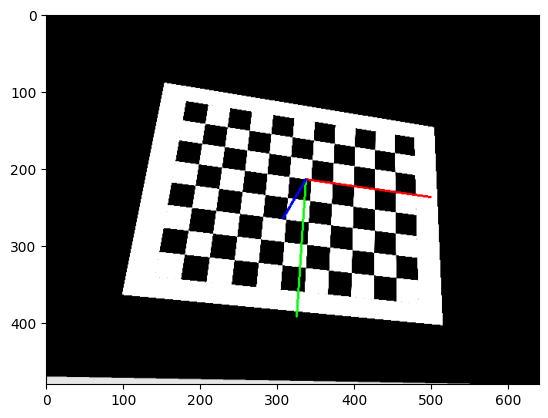

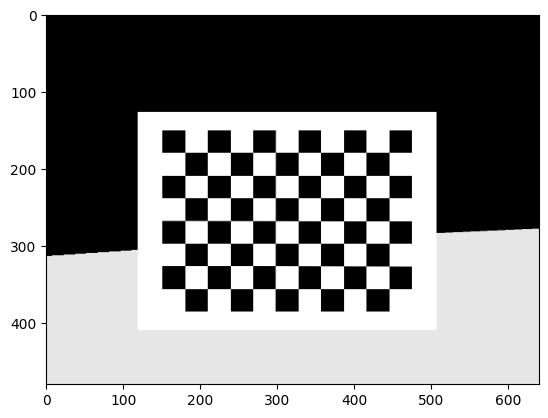

0.0 0.0


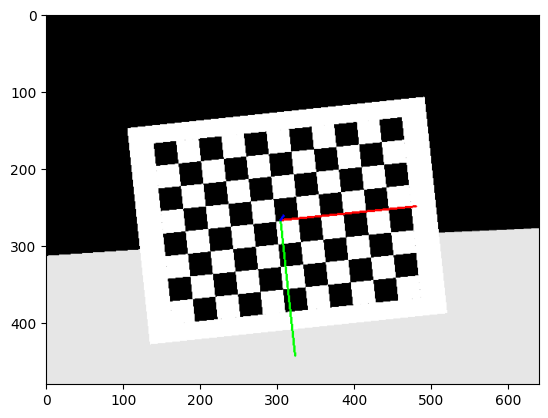

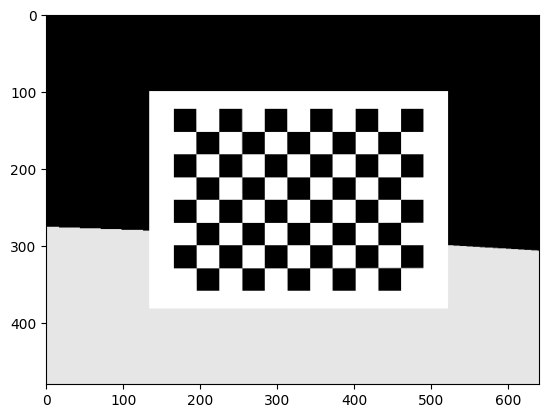

0.0 0.0


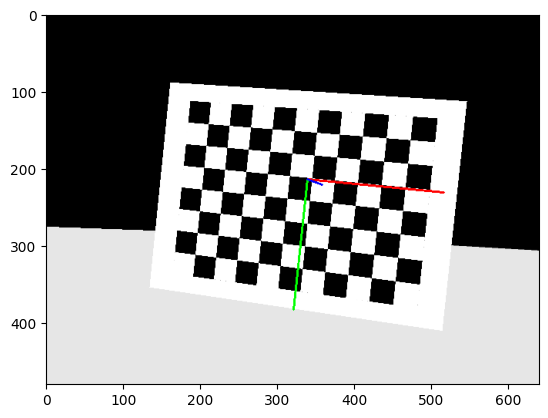

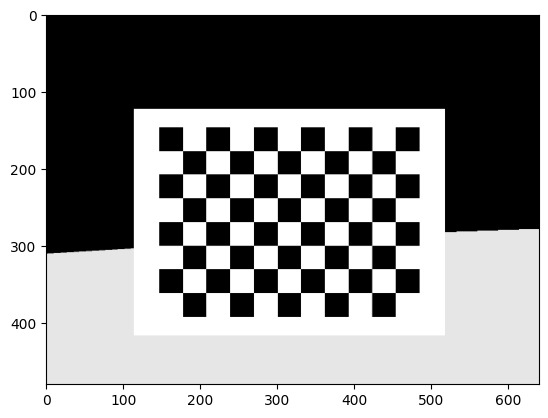

0.0 0.0


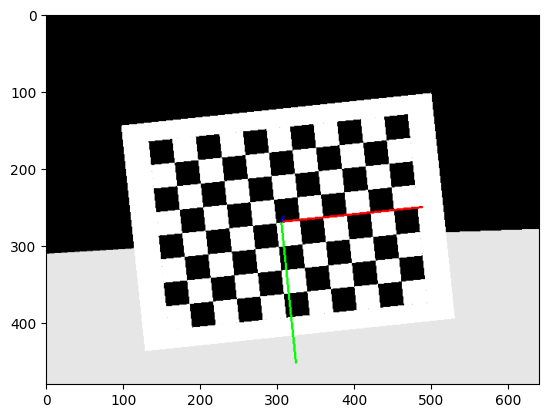

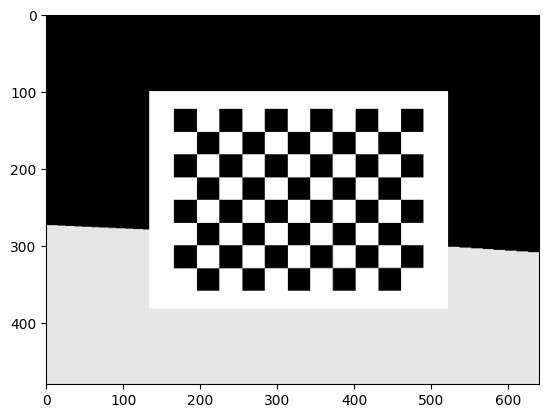

In [39]:
for T in Ts:
    T_target = T_target_original@T
    ret, r_err, t_err = set_frame_pose_and_wait(sim, ur_base, checkerboard_frame, checkerboard_frame, T_target)
    if not ret:
        continue
    img = get_cv2_bgr(cam2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
    if not ret:
        continue
    print(r_err, t_err)
    corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    ret, rvec, tvec = cv2.solvePnP(objp, corners, mtx2, dist2, flags=cv2.SOLVEPNP_SQPNP)
    if not ret:
        continue

    T_w2c = np.eye(4, dtype=np.float32)
    T_w2c[:3,:3] = cv2.Rodrigues(rvec)[0]
    T_w2c[:3,-1] = tvec.ravel()
    T_w2c = T_t2center @ T_w2c

    vis = cv2.drawFrameAxes(img.copy(), mtx2, dist2, cv2.Rodrigues(T_w2c[:3,:3])[0], T_w2c[:3,-1], 0.15, 2)
    plt.imshow(vis[...,::-1])
    plt.show()
    
    T_base2ee = get_frame_pose(sim, ur_base, ur_ee)
    T_new_ee = T_base2ee @ T_tcp2 @ T_w2c @ T_backward @ np.linalg.inv(T_tcp2)
    
    set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_new_ee)

    img = get_cv2_bgr(cam2)
    plt.imshow(img[...,::-1])
    plt.show()

In [40]:
set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_original)
set_frame_pose_and_wait(sim, ur_base, checkerboard_frame, checkerboard_frame, T_target_original)

(True, 0.0, 0.0)

In [41]:
# Interactive Tracking in Simulator

while True:
    img = get_cv2_bgr(cam2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
    if not ret:
        continue
    corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    ret, rvec, tvec = cv2.solvePnP(objp, corners, mtx2, dist2, flags=cv2.SOLVEPNP_SQPNP)
    if not ret:
        continue

    T_w2c = np.eye(4, dtype=np.float32)
    T_w2c[:3,:3] = cv2.Rodrigues(rvec)[0]
    T_w2c[:3,-1] = tvec.ravel()
    T_w2c = T_t2center @ T_w2c
    
    T_base2ee = get_frame_pose(sim, ur_base, ur_ee)
    T_new_ee = T_base2ee @ T_tcp2 @ T_w2c @ T_backward @ np.linalg.inv(T_tcp2)
    
    set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_new_ee)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10496ca30>>
Traceback (most recent call last):
  File "/Users/kuang-yujeng/torchenv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 